In [1]:
# Import

import numpy
import torch
import nufft
import yaml

import sys
sys.path.append('..')

from harmonica.util import LENGTH
from harmonica.statistics import weighted_mean, weighted_variance
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())
print(torch.get_num_threads())

True
2


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

# Example-01: FFT amplitude spectrum

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))


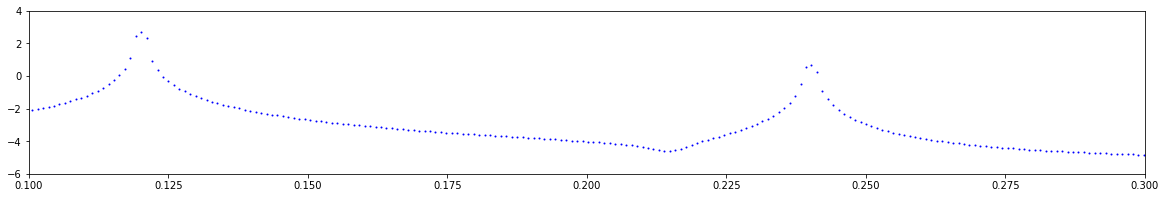

In [3]:
# Set parameters (64 signals with length 1024)

size, length = 64, 1024

# Set window

w = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(w)

# Set TbT data (64 signals with two components and different amplitudes)

t = torch.linspace(1.0, length, length, dtype=dtype, device=device)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
d = Data.from_data(w, data)
print(d)

# Initialize Frequency instance

f = Frequency(d)
print(f)

# Apply window (note, window is applied to work)

d.window_remove_mean()
d.window_apply()

# FFT grid is stored in fft_grid (computed on initialization)
# FFT spectrum amplitudes are stored in fft_spectrum for each signal

# Compute FFT amplitude spectrum

f.fft_get_spectrum()

# Reset TbT work (copy data to work)

f.data.reset()

# Plot (log10) FFT spectrum for given signal id

idx = 0
plt.figure(figsize=(20, 3))
plt.scatter(f.fft_grid.cpu().numpy(), torch.log10(f.fft_spectrum[idx]).cpu().numpy(), s=1, c='blue')
plt.xlim(0.1, 0.3)
plt.ylim(-6.0, 4.0)
plt.show()

# Clean

del w
del t, data
del d
del f
if device != torch.device('cpu'):
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-02: FFT amplitude spectrum & zero padding

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))


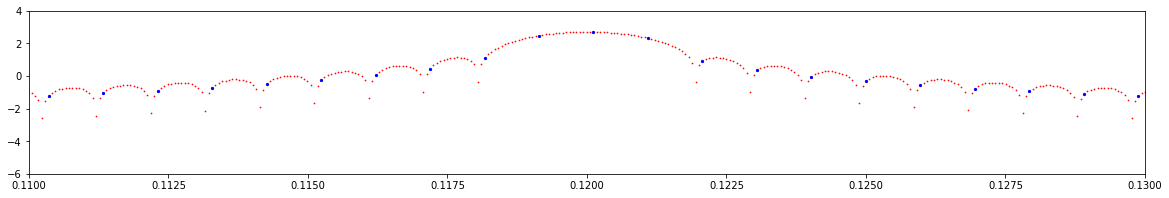

In [4]:
# Set parameters (64 signals with length 1024)

size, length = 64, 1024

# Set window

w = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(w)

# Set TbT data (64 signals with two components and different amplitudes)

t = torch.linspace(1.0, length, length, dtype=dtype, device=device)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
d = Data.from_data(w, data)
print(d)

# If pad == 0, it is set to signal length
# Spectrum is computed using torch.fft.rfft(..., n=pad)/torch.fft.fft(..., n=pad) for real/complex input
# Padding can be used to interpolate DTFT spectrum in all frequency range
# This improves frequency estimation accuracy (assuming frequency corresponds to max of the largest FFT spectrum amplitude peak)
# Can be used to obtain a better initial guess, if signal has several frequencies with close amplitudes

# Initialize Frequency instances with and without padding

f1 = Frequency(d, pad=length*2**4)
f2 = Frequency(d, pad=length*2**0)
print(f1)
print(f2)

# Apply window (note, window is applied to work)

d.window_remove_mean()
d.window_apply()

# Compute FFT amplitude spectrum

f1.fft_get_spectrum()
f2.fft_get_spectrum()

# Reset TbT work

f1.data.reset()
f2.data.reset()


# Plot (log10) FFT spectrum for given signal id

idx = 0
plt.figure(figsize=(20, 3))
plt.scatter(f1.fft_grid.cpu().numpy(), torch.log10(f1.fft_spectrum[idx]).cpu().numpy(), s=0.5, c='red')
plt.scatter(f2.fft_grid.cpu().numpy(), torch.log10(f2.fft_spectrum[idx]).cpu().numpy(), s=5.0, c='blue')
plt.xlim(0.12 - 0.01, 0.12 + 0.01)
plt.ylim(-6.0, 4.0)
plt.show()

# Clean

del w
del t, data
del d
del f1, f2
if device != torch.device('cpu'):
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-03: FFT frequency estimation & zero padding

In [5]:
# FFT frequency estimation is based on location of max bin in the amplitude spectum

# Set parameters (64 signals with length 1024)

size, length = 64, 1024

# Set window

w = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(w)

# Set TbT data (64 signals with two components and different amplitudes)

t = torch.linspace(1.0, length, length, dtype=dtype, device=device)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
d = Data.from_data(w, data)
print(d)

# Initialize Frequency instances with and without padding

f1 = Frequency(d, pad=length*2**0)
f2 = Frequency(d, pad=length*2**4)
print(f1)
print(f2)

# Apply window (note, window is applied to work)

d.window_remove_mean()
d.window_apply()

# Estimate frequency

f1('fft')
f2('fft')

# Compare results

print(torch.abs(f1.frequency.mean() - 0.12))
print(torch.abs(f2.frequency.mean() - 0.12))

# In this case call invokes task_fft method

f1.compute_fft()
f2.compute_fft()

# Compare results

print(torch.abs(f1.fft_frequency.mean() - 0.12))
print(torch.abs(f2.fft_frequency.mean() - 0.12))

# Clean

del w
del t, data
del d
del f1, f2
if device != torch.device('cpu'):
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(4.882812499996e-06, dtype=torch.float64)
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(4.882812499996e-06, dtype=torch.float64)


# Example-04: FFT frequency estimation & zero padding for given range

In [6]:
# Set parameters (64 signals with length 1024)

size, length = 64, 1024

# Set window

w = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(w)

# Set TbT data (64 signals with two components and different amplitudes)

t = torch.linspace(1.0, length, length, dtype=dtype, device=device)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
d = Data.from_data(w, data)
print(d)

# Initialize Frequency instances with and without padding

f1 = Frequency(d, pad=length*2**0)
f2 = Frequency(d, pad=length*2**4)
print(f1)
print(f2)

# Apply window (note, window is applied to work)

d.window_remove_mean()
d.window_apply()

# By default FFT frequency estimation is performed using (0.0, 0.5) frequency range.
# Explicit range can be passed.

# Estimate frequency for explicit frequency range

f1('fft', f_range=(0.2, 0.25))
f2('fft', f_range=(0.2, 0.25))

# Compare results

print(torch.abs(f1.frequency.mean() - 0.24))
print(torch.abs(f2.frequency.mean() - 0.24))

# Clean

del w
del t, data
del d
del f1, f2
if device != torch.device('cpu'):
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))
tensor(2.343750000000e-04, dtype=torch.float64)
tensor(9.765624999991e-06, dtype=torch.float64)


# Example-05: FFRFT/ZOOM amplitude spectrum

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))
tensor([1.191406250000e-01, 1.210918426514e-01], dtype=torch.float64)
tensor([1.191406250000e-01, 1.210937500000e-01], dtype=torch.float64)
tensor([1.191406250000e-01, 1.210937500000e-01], dtype=torch.float64)


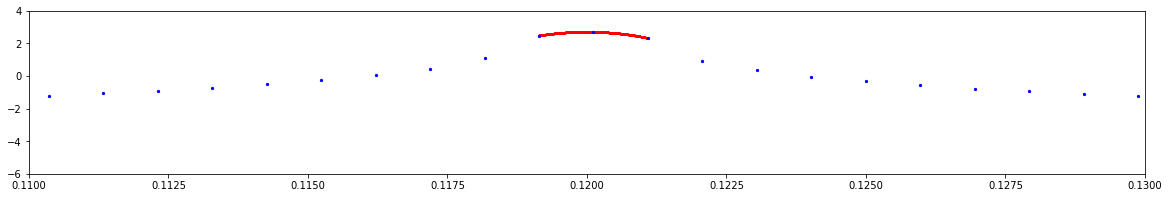

tensor([1.150000000000e-01, 1.249902343750e-01], dtype=torch.float64)
tensor([1.150000000000e-01, 1.250000000000e-01], dtype=torch.float64)


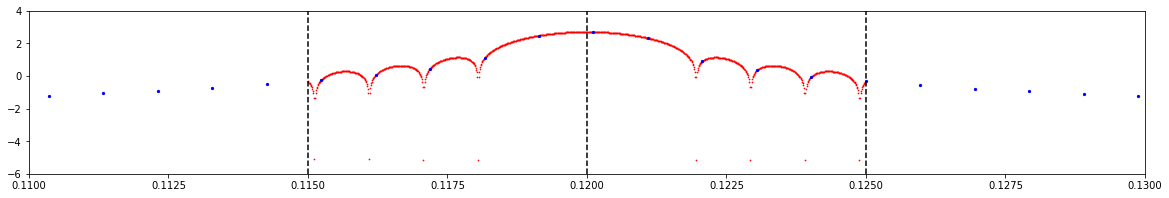

In [7]:
# FFRFT can be used for local DTFT spectrum interpolation

# Set parameters (64 signals with length 1024)

size, length = 64, 1024

# Set window

w = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(w)

# Set TbT data (64 signals with two components and different amplitudes)

t = torch.linspace(1.0, length, length, dtype=dtype, device=device)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
d = Data.from_data(w, data)
print(d)

# Initialize Frequency instance

f = Frequency(d)
print(f)

# Apply window (note, window is applied to work)

d.window_remove_mean()
d.window_apply()

# Compute FFT amplitude spectrum

f.fft_get_spectrum()

# By default for FFRFT spectrum, FFT frequency estimation is used
# And frequency range is equal to 2 FFT bins around max FFT bin
# This can be changed by setting fraction parameter on initialization
# Or by setting ffrft_span attibute directry after initialization
# Use default value.

f.ffrft_span = 2.0/f.length

# If ffrft_flag is False, ffrft_initialize_spectrum is invoked
# ffrft_flag is set to True, futher calls do not reinitialize FFRFT
# No need to initialize for fixed signal length

# Compute FFT frequency estimation (used to define FFRFT frequency center)

f.fft_get_frequency()

# Compute FFRFT amplitude spectrum

f.ffrft_get_spectrum()

# Note, last point is not included

print(torch.stack([f.ffrft_get_grid(0)[0], f.ffrft_get_grid(0)[-1]]))
print(torch.stack([f.ffrft_get_grid(0)[0], f.ffrft_get_grid(0)[-1] + f.ffrft_span*f.fft_step]))
print(torch.stack([f.fft_frequency[0] - f.fft_step, f.fft_frequency[0] + f.fft_step]))

# Plot (log10) FFT spectrum for given signal id

idx = 0
plt.figure(figsize=(20, 3))
plt.scatter(f.ffrft_get_grid(idx).cpu(), torch.log10(f.ffrft_spectrum[idx].cpu()), s=0.5, c='r')
plt.scatter(f.fft_grid.cpu(), torch.log10(f.fft_spectrum[idx].cpu()), s=5.0, c='b')
plt.xlim(0.12 - 0.01, 0.12 + 0.01)
plt.ylim(-6.0, 4.0)
plt.show()

# FFRFT can be used with custom range
# In this case all signals share this range, while for the default case, each signal range is defined by its FFT frequency
# In all cases range length is the same for all signals

# Compute FFRFT amplitude spectrum with custom range
# Range (f_min, f_max) = (center - 0.5*span, center + 0.5*span - span/length)

f.ffrft_get_spectrum(center=0.12, span=0.01)

# Note, last point is not included

print(torch.stack([f.ffrft_get_grid(0)[0], f.ffrft_get_grid(0)[-1]]))
print(torch.stack([f.ffrft_get_grid(0)[0], f.ffrft_get_grid(0)[-1] + f.ffrft_span*f.fft_step]))

# Plot (log10) FFT spectrum for given signal id

idx = 0
plt.figure(figsize=(20, 3))
plt.scatter(f.ffrft_get_grid(idx).cpu().numpy(), torch.log10(f.ffrft_spectrum[idx]).cpu().numpy(), s=0.5, c='red')
plt.scatter(f.fft_grid.cpu().numpy(), torch.log10(f.fft_spectrum[idx]).cpu().numpy(), s=5.0, c='blue')
plt.xlim(0.12 - 0.01, 0.12 + 0.01)
plt.ylim(-6.0, 4.0)
plt.vlines(0.12, -6.0, 4.0, colors='black', linestyles='dashed')
plt.vlines(0.12 - 0.01/2, -6.0, 4.0, colors='black', linestyles='dashed')
plt.vlines(0.12 + 0.01/2, -6.0, 4.0, colors='black', linestyles='dashed')
plt.show()

# Clean

del w
del t, data
del d
del f
if device != torch.device('cpu'):
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-06: FFRFT/ZOOM frequency estimation

In [8]:
# FFRFT frequency estimation is based on local DTFT spectrum interpolation (near expected global maximum)
# By default refined spectum is computed inside two FFT bins around maximum bin
# In this case expected frequency error is proportional to 1/n^2

# Set parameters (64 signals with length 1024)

size, length = 64, 1024

# Set window

w = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(w)

# Set TbT data (64 signals with two components and different amplitudes)

t = torch.linspace(1.0, length, length, dtype=dtype, device=device)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
d = Data.from_data(w, data)
print(d)

# Initialize Frequency instance

f1 = Frequency(d)
f2 = Frequency(d, pad=8192, fraction=1.0)
print(f1)
print(f2)

# Apply window (note, window is applied to work)

d.window_remove_mean()
d.window_apply()

# Fraction between 1.0-2.0 should be save to use

# Estimate frequency, see also task_ffrft

f1('ffrft')
f2('ffrft')

# Compare results FFT & FFRFT estimations

print(torch.abs(f1.fft_frequency.mean() - 0.12))
print(torch.abs(f2.fft_frequency.mean() - 0.12))
print(torch.abs(f1.ffrft_frequency.mean() - 0.12))
print(torch.abs(f2.ffrft_frequency.mean() - 0.12))

# Clean

del w
del t, data
del d
del f1, f2
if device != torch.device('cpu'):
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(4.882812499996e-06, dtype=torch.float64)
tensor(8.392333984419e-07, dtype=torch.float64)
tensor(1.144409179643e-07, dtype=torch.float64)


# Example-07: Parabola frequency estimation

In [9]:
# Parabola frequency estimation is based on parabolic interpolation of FFRFT amplitude spectrum
# Three points are used to locate parabola maximum (FFRFT max bin and two poins around it)
# Higher order polynomial can be used or a gradient free bracketing maximum search
# Instead of interpolation, a polynomial (e.g. a parabola) can be fitted near the peak maximum
# Without noise, parabolic interpolation significantly improves estimation accuracy
# Window order impoves accuracy in this case too (flat top)
# With noise accuracy gain from parabolic interpolation decreases
# Application of window increases noise

# Set parameters (64 signals with length 1024)

size, length = 64, 1024

# Set window

w = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(w)

# Set TbT data (64 signals with two components and different amplitudes)

t = torch.linspace(1.0, length, length, dtype=dtype, device=device)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
d = Data.from_data(w, data)
print(d)

# Initialize Frequency instance

f = Frequency(d)
print(f)

# Apply window (note, window is applied to work)

d.window_remove_mean()
d.window_apply()

# Estimate frequency, see also task_parabola

f('parabola')

# Compare results

print(torch.abs(torch.mean(f.fft_frequency) - 0.12))
print(torch.abs(torch.mean(f.ffrft_frequency) - 0.12))
print(torch.abs(torch.mean(f.parabola_frequency) - 0.12))

# Candan frequency estimation

# Note, this estimator performs well for a complex signal with one component

print(torch.abs(f.candan_get_frequency().mean() - 0.12))

# Clean

del w
del t, data
del d
del f
if device != torch.device('cpu'):
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(1024, 'cosine_window', 1.0)
Data(64, Window(1024, 'cosine_window', 1.0))
Frequency(Data(64, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(8.392333984419e-07, dtype=torch.float64)
tensor(3.024490380366e-11, dtype=torch.float64)
tensor(5.859356676086e-05, dtype=torch.float64)


# Example-08: Frequency vs signal start shift

Window(8192, 'cosine_window', 1.0)
Data(1, Window(8192, 'cosine_window', 1.0))
Data(7169, Window(1024, 'cosine_window', 1.0))
Frequency(Data(7169, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(8.392333984419e-07, dtype=torch.float64)
tensor(1.861150122906e-13, dtype=torch.float64)


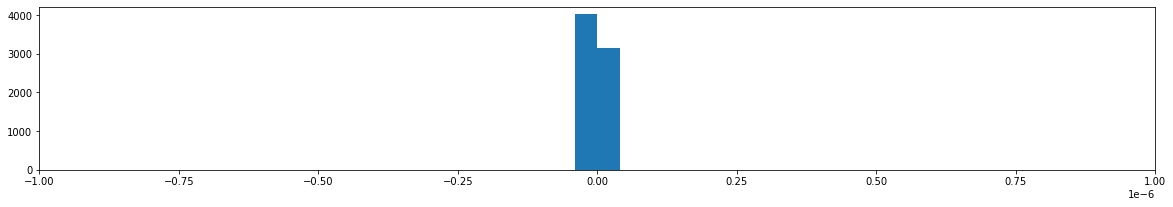

tensor(2.584960914924e-11, dtype=torch.float64)


In [10]:
# Set parameters (1 signal with length 8192)

size, length = 1, 8192

# Set window

w = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(w)

# Set TbT data (1 signals with two components)

t = torch.linspace(1.0, length, length, dtype=dtype, device=device)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
d = Data.from_data(w, data)
print(d)

# Generate matrix shifted signal

data = d.make_matrix(1024, 1, d.data[0])
w = Window.from_cosine(1024, order=1.0, dtype=dtype, device=device)
d = Data.from_data(w, data)
print(d)

# Initialize Frequency instance

f = Frequency(d)
print(f)

# Apply window (note, window is applied to work)

d.window_remove_mean()
d.window_apply()

# Estimate frequency, see also task_parabola

f('parabola')

# Compare results

print(torch.abs(torch.mean(f.fft_frequency) - 0.12))
print(torch.abs(torch.mean(f.ffrft_frequency) - 0.12))
print(torch.abs(torch.mean(f.parabola_frequency) - 0.12))

# Plot result

plt.figure(figsize=(20, 3))
plt.hist(100*(f.frequency.cpu().numpy() - 0.12)/0.12, bins=50, range=(-1.0E-6, +1.0E-6))
plt.xlim(-1.0E-6, +1.0E-6)
plt.show()

# Spread

print(f.parabola_frequency.std().cpu())

# Clean

del w
del t, data
del d
del f
if device != torch.device('cpu'):
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-09: Frequency vs signal start shift (noise)

Window(8192, 'cosine_window', 1.0)
Data(1, Window(8192, 'cosine_window', 1.0))
Data(7169, Window(1024, 'cosine_window', 1.0))
Frequency(Data(7169, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(1.498847713444e-07, dtype=torch.float64)
tensor(6.349271539086e-09, dtype=torch.float64)


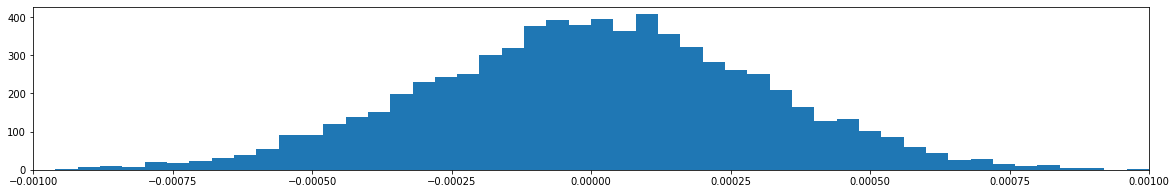

tensor(3.580563340945e-07, dtype=torch.float64)


In [11]:
# Set parameters (1 signal with length 8192)

size, length = 1, 8192

# Set window

w = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(w)

# Set TbT data (1 signals with two components)

t = torch.linspace(1.0, length, length, dtype=dtype, device=device)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
d = Data.from_data(w, data)
print(d)

# Generate matrix shifted signal

data = d.make_matrix(1024, 1, d.data[0])
w = Window.from_cosine(1024, order=1.0, dtype=dtype, device=device)
d = Data.from_data(w, data)
print(d)

# Add noise to each signal

for i in range(d.size):
    d.data[i] += 0.01*torch.randn(d.length, dtype=dtype, device=device)
d.reset()

# Initialize Frequency instance

f = Frequency(d)
print(f)

# Apply window (note, window is applied to work)

d.window_remove_mean()
d.window_apply()

# Estimate frequency, see also task_parabola

f('parabola')

# Compare results

print(torch.abs(torch.mean(f.fft_frequency) - 0.12))
print(torch.abs(torch.mean(f.ffrft_frequency) - 0.12))
print(torch.abs(torch.mean(f.parabola_frequency) - 0.12))

# Plot result

plt.figure(figsize=(20, 3))
plt.hist(100*(f.frequency.cpu().numpy() - 0.12)/0.12, bins=50, range=(-1.0E-3, +1.0E-3))
plt.xlim(-1.0E-3, +1.0E-3)
plt.show()

# Spread

print(f.parabola_frequency.std().cpu())

# Clean

del w
del t, data
del d
del f
if device != torch.device('cpu'):
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-10: Frequency vs signal start shift (correlated noise)

Window(8192, 'cosine_window', 1.0)
Data(1, Window(8192, 'cosine_window', 1.0))
Data(7169, Window(1024, 'cosine_window', 1.0))
Frequency(Data(7169, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))
tensor(1.171875000000e-04, dtype=torch.float64)
tensor(4.718752316668e-08, dtype=torch.float64)
tensor(3.801875661513e-09, dtype=torch.float64)


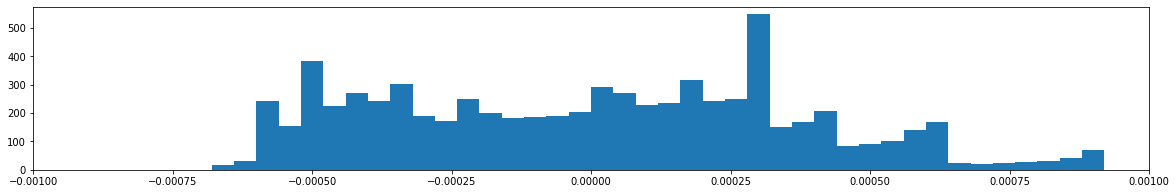

tensor(4.421903935670e-07, dtype=torch.float64)


In [134]:
# Set parameters (1 signal with length 8192)

size, length = 1, 8192

# Set window

w = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)
print(w)

# Set TbT data (1 signals with two components and random noise)

t = torch.linspace(1.0, length, length, dtype=dtype, device=device)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*t) for i in range(1, size + 1)])
data += 0.01*torch.randn(length, dtype=dtype, device=device)
d = Data.from_data(w, data)
print(d)

s = torch.clone(data.squeeze()).numpy()

# Generate matrix shifted signal

data = d.make_matrix(1024, 1, d.data[0])
w = Window.from_cosine(1024, order=1.0, dtype=dtype, device=device)
d = Data.from_data(w, data)
print(d)

# Initialize Frequency instance

f = Frequency(d)
print(f)

# Apply window (note, window is applied to work)

d.window_remove_mean()
d.window_apply()

# Estimate frequency, see also task_parabola

f('parabola')

# Compare results

print(torch.abs(torch.mean(f.fft_frequency) - 0.12))
print(torch.abs(torch.mean(f.ffrft_frequency) - 0.12))
print(torch.abs(torch.mean(f.parabola_frequency) - 0.12))

# Plot result

plt.figure(figsize=(20, 3))
plt.hist(100*(f.frequency.cpu().numpy() - 0.12)/0.12, bins=50, range=(-1.0E-3, +1.0E-3))
plt.xlim(-1.0E-3, +1.0E-3)
plt.show()

# Spread

print(f.parabola_frequency.std().cpu())

# # Clean

# del w
# del t, data
# del d
# del f
# if device != torch.device('cpu'):
#     torch.cuda.synchronize()
#     torch.cuda.empty_cache()

# Example-11: Iterative decomposition

[2.]
[0.12 1.   0.1 ]
[0.24  0.005 0.01 ]
[3.6e-01 1.0e-04 1.0e-05]


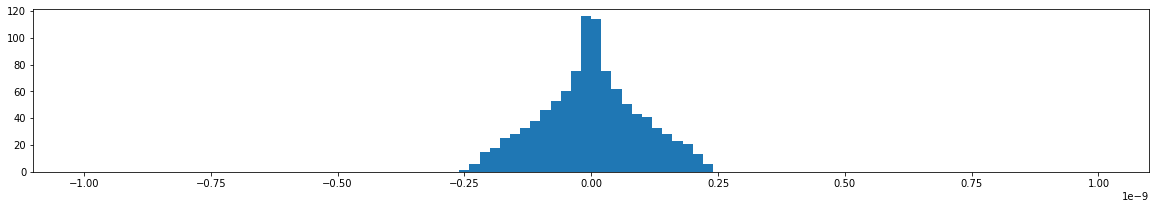

9.731337653646109e-11


In [13]:
# Set parameters

size, length = 1, 1024

# Set window

w = Window.from_cosine(length, order=4.0, dtype=dtype, device=device)

# Set data

t  = torch.linspace(0.0, length-1, length, dtype=dtype, device=device)
data  = 1.0000*torch.cos(2.0*numpy.pi*1*0.12*t) + 0.10000*torch.sin(2.0*numpy.pi*1*0.12*t)
data += 0.0050*torch.cos(2.0*numpy.pi*2*0.12*t) + 0.01000*torch.sin(2.0*numpy.pi*2*0.12*t)
data += 0.0001*torch.cos(2.0*numpy.pi*3*0.12*t) + 0.00001*torch.sin(2.0*numpy.pi*3*0.12*t)
data += 2.0
data  = torch.stack([data])
d = Data.from_data(w, data)

# Compute (window weighted) mean value

print(d.window_mean().flatten().cpu().numpy())

# Remove (window weighted) mean value
# Note, mean is removed from work

d.window_remove_mean()
d.data.copy_(d.work)

# Initialize Frequency instance

f = Frequency(d)

# Perform decomposition (component-by-component subtraction)

for _ in range(3):
    
    # Remove mean and apply window
    
    d.window_apply()
    
    # Estimate main harmonic frequency
    
    f('parabola')
    frequency = f.frequency[0]
    
    # Estimate main harmonic parameters
    
    cos = 2.0*torch.dot(d.data[0]*w.window, torch.cos(2.0*numpy.pi*frequency*t))/w.total
    sin = 2.0*torch.dot(d.data[0]*w.window, torch.sin(2.0*numpy.pi*frequency*t))/w.total
    
    # Subtract harmonic
    
    harmonic = cos*torch.cos(2.0*numpy.pi*frequency*t) + sin*torch.sin(2.0*numpy.pi*frequency*t)
    d.data.sub_(harmonic)
    
    # Reset work
    
    d.reset()
    
    # Print result
    
    print(torch.stack([frequency, cos, sin]).cpu().numpy())
    

# Plot residual

plt.figure(figsize=(20, 3))
plt.hist(d.data[0].cpu().numpy(), bins=100, range=(-1.0E-9, +1.0E-9))
plt.show()

# Residual spread

print(d.data.std().item())

# Clean

del w
del t, data
del d
del f
if device != torch.device('cpu'):
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-12: Joined frequency (direct computation)

In [14]:
# Set window

w = Window(4096, name='cosine_window', order=1.0, dtype=dtype, device=device)

# Load test TbT data from file (linear lattice without noise)

d = Data.from_file(54, w, '../virtual_tbt.npy')

# Remove mean and apply window

d.window_remove_mean()
d.window_apply()

# Compute reference frequency

f = Frequency(d)
f('parabola')
ref = f.frequency.mean()
print(ref.item())

# Generate mixed signal

keep = 32
data = d.data[:, :keep]
data = (data - data.mean(1).reshape(-1, 1))/data.std(1).reshape(-1, 1)
data = d.make_signal(keep, data)

# Generate window and TbT for mixed signal

w = Window(len(data), name='cosine_window', order=1.0, dtype=dtype, device=device)
d = Data.from_data(w, data.reshape(1, -1))
d.window_apply()

# Compute frequency

f = Frequency(d)
f('parabola', f_range=(8.5/54, 8.6/54))
res = 9.0 - 54*f.frequency.mean()
print(res.item())

# Compare

print((ref - res).item())

# Note, the above is also avalible as a separate method (work container is used)

w = Window(4096, name='cosine_window', order=1.0, dtype=dtype, device=device)
d = Data.from_file(54, w, '../virtual_tbt.npy')
f = Frequency(d)
*_, res = 9.0 - f.compute_joined_frequency(length=keep, f_range=(8.5, 8.6), order=1.0)
print(res.item())

# Clean

del w
del data
del d
del f
if device != torch.device('cpu'):
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

0.46311690126299115
0.4631161977901517
7.034728394805789e-07
0.4631161977901517


# Example-13: Mean spectrum

Window(4096, 'cosine_window', 1.0)
Data(54, Window(4096, 'cosine_window', 1.0))
Frequency(Data(54, Window(4096, 'cosine_window', 1.0)), f_range=(0.0, 0.5))


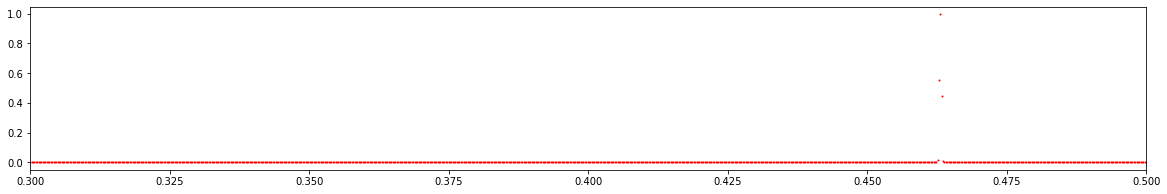

In [15]:
# Set window

w = Window(4096, name='cosine_window', order=1.0, dtype=dtype, device=device)
print(w)

# Load TbT data from file and add noise

d = Data.from_file(54, w, '../virtual_tbt.npy')
s = 1.0E-4*torch.ones(54, dtype=dtype, device=device)
d.add_noise(s)
print(d)

# Apply window (note, window is applied to work)

d.window_remove_mean()
d.window_apply()

# Initialize Frequency instance

f = Frequency(d)
print(f)

# Compute frequencies
# self.frequency container is used for normalization of each signal spectrum

f('parabola')

# Compute mean spectrum
# Note, spectra are not recomputed, normalization and averaging is performed

grid, spectrum = f.compute_mean_spectrum(log=False)

# Plot mean spectrum

plt.figure(figsize=(20, 3))
plt.xlim(0.3, 0.5)
plt.scatter(grid.cpu(), spectrum.cpu(), s=1, c='r')
plt.show()

# Clean

del w
del d
del f
del grid, spectrum
if device != torch.device('cpu'):
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-14: Joined spectrum

Window(4096, 'cosine_window', 1.0)
Data(54, Window(4096, 'cosine_window', 1.0))
Frequency(Data(54, Window(4096, 'cosine_window', 1.0)), f_range=(0.0, 0.5))


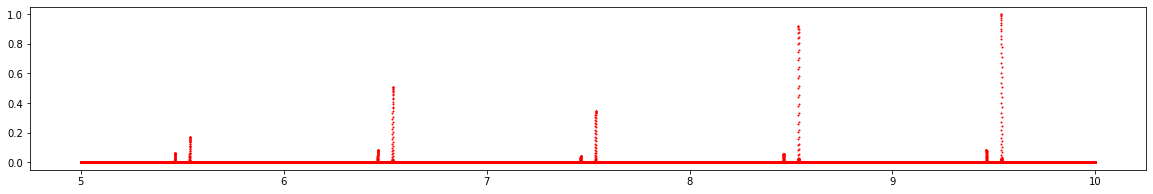

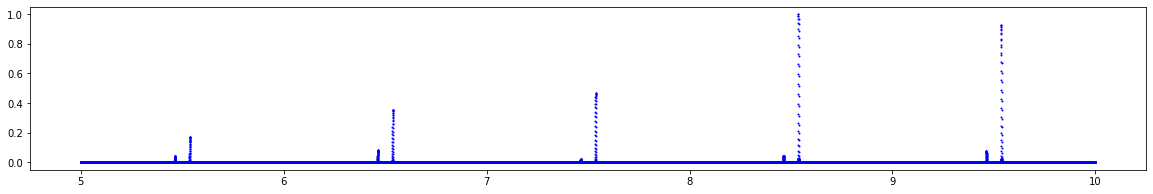

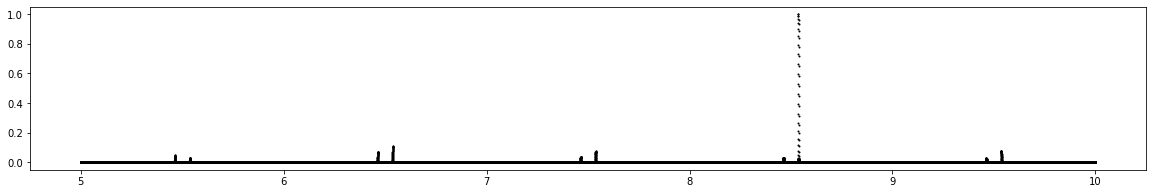

In [16]:
# Load model data

with open('../config.yaml', 'r') as stream:
    config = yaml.safe_load(stream)
    config = {key: config[key] for key in sorted(config.keys(), key=lambda name: config[name]['TIME'])}

# Set normalized positions (used as locations with NUFFT)

position = numpy.array([value['TIME'] for key, value in config.items() if value['TYPE'] == 'MONITOR'])/LENGTH

# Set normalized accumulated phase advance between given monitor location and the next monitor location (used as locations with NUFFT)

phase = numpy.array([value['FX'] for key, value in config.items() if value['TYPE'] == 'MONITOR' or key == 'TAIL'])
*_, tune = phase
phase = numpy.diff(phase)
phase = numpy.cumsum(phase)/tune
start, *_ = phase
phase = phase - start

# Set window

w = Window(4096, name='cosine_window', order=1.0, dtype=dtype, device=device)
print(w)

# Load TbT data from file and add noise

d = Data.from_file(54, w, '../virtual_tbt.npy')
s = 1.0E-4*torch.ones(54, dtype=dtype, device=device)
d.add_noise(s)
print(d)

# Initialize Frequency instance

f = Frequency(d)
print(f)

# Compute & plot mixed spectrum

f_range=(5.0, 10.0)
s1 = f.compute_joined_spectrum(length=1024, normalize=True, f_range=f_range, name='cosine_window', order=1.0, position=None)
s2 = f.compute_joined_spectrum(length=1024, normalize=True, f_range=f_range, name='cosine_window', order=1.0, position=position)
s3 = f.compute_joined_spectrum(length=1024, normalize=True, f_range=f_range, name='cosine_window', order=1.0, position=phase)
plt.figure(figsize=(20, 3))
plt.scatter(*s1, c='red', s=1)
plt.show()
plt.figure(figsize=(20, 3))
plt.scatter(*s2, c='blue', s=1)
plt.show()
plt.figure(figsize=(20, 3))
plt.scatter(*s3, c='black', s=1)
plt.show()

# Clean

del w
del d
del f
del s1, s2, s3
if device != torch.device('cpu'):
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    
# s1 -- (red)   pre-normalized mixed signal treated as if it is uniformly sampled
# s2 -- (blue)  pre-normalized mixed signal and type-iii nufft with BPM normalized position as location
# s3 -- (black) pre-normalized mixed signal and type-iii nufft with BPM normalized accumulated phase as location

# As it can be seen, here s1 gives wrong integer part (location of peak with maximum amplitude)
# But this is not always the case, filtering by beta function or phase can resolve this

# Normalization is performed before to mixing to make mixed signal closer to a stationary one
# Another option to reduce the effect of signal being non-stationary is to scale it with beta function
# Or to remove BPMs where amplitudes are not close enough, e.g. near IP

# Example-15: Joined frequency (method)

In [17]:
# Load model data

with open('../config.yaml', 'r') as stream:
    config = yaml.safe_load(stream)
    config = {key: config[key] for key in sorted(config.keys(), key=lambda name: config[name]['TIME'])}

# Set normalized positions (used as locations with NUFFT)

position = numpy.array([value['TIME'] for key, value in config.items() if value['TYPE'] == 'MONITOR'])/LENGTH

# Set normalized accumulated phase advance between given monitor location and the next monitor location (used as locations with NUFFT)

phase = numpy.array([value['FX'] for key, value in config.items() if value['TYPE'] == 'MONITOR' or key == 'TAIL'])
*_, tune = phase
phase = numpy.diff(phase)
phase = numpy.cumsum(phase)/tune
start, *_ = phase
phase = phase - start
tune = tune/(2.0*numpy.pi)

# Set window

w = Window(4096, name='cosine_window', order=2.0, dtype=dtype, device=device)
print(w)

# Load TbT data from file

d = Data.from_file(54, w, '../virtual_tbt.npy')
print(d)

# Initialize Frequency instance

f = Frequency(d)
print(f)

# Compute reference frequency

d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
mean = 9.0 - torch.mean(f.frequency).item()
std = torch.std(f.frequency).item()
print(tune)
print(mean)
print(abs(mean-tune))
print(std)

# Compute mixed frequencies in given range
# Note, for small number of turns, result might be more accurate without window (set order to zero)
# For large number of turns 'uniform' case is more accurate (might indicate a numerical problem with nufft)

length = 32
f1 = f.compute_joined_frequency(length=length, f_range=(8.5,9.0), order=1.0, normalize=True)
f2 = f.compute_joined_frequency(length=length, f_range=(8.5,9.0), order=1.0, normalize=True, position=position)
f3 = f.compute_joined_frequency(length=length, f_range=(8.5,9.0), order=1.0, normalize=True, position=phase)
print(f1.cpu().numpy())
print(f2.cpu().numpy())
print(f3.cpu().numpy())
print((f1 - tune).abs().cpu().numpy())
print((f2 - tune).abs().cpu().numpy())
print((f3 - tune).abs().cpu().numpy())

# Clean

del w
del d
del f
del f1, f2, f3
if device != torch.device('cpu'):
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(4096, 'cosine_window', 2.0)
Data(54, Window(4096, 'cosine_window', 2.0))
Frequency(Data(54, Window(4096, 'cosine_window', 2.0)), f_range=(0.0, 0.5))
8.536883098737361
8.536883098737315
4.618527782440651e-14
3.2377265211256743e-16
[8.53125    8.53689236 8.5368838 ]
[8.53676896 8.53689084 8.53689098]
[8.53676896 8.53687776 8.53687766]
[5.63309874e-03 9.26237375e-06 7.03472487e-07]
[1.14135217e-04 7.74121759e-06 7.87946758e-06]
[1.14135217e-04 5.33493356e-06 5.44336398e-06]


# Example-16: Joined frequency (method, with noise)

In [18]:
# Load model data

with open('../config.yaml', 'r') as stream:
    config = yaml.safe_load(stream)
    config = {key: config[key] for key in sorted(config.keys(), key=lambda name: config[name]['TIME'])}

# Set normalized positions (used as locations with NUFFT)

position = numpy.array([value['TIME'] for key, value in config.items() if value['TYPE'] == 'MONITOR'])/LENGTH

# Set normalized accumulated phase advance between given monitor location and the next monitor location (used as locations with NUFFT)

phase = numpy.array([value['FX'] for key, value in config.items() if value['TYPE'] == 'MONITOR' or key == 'TAIL'])
*_, tune = phase
phase = numpy.diff(phase)
phase = numpy.cumsum(phase)/tune
start, *_ = phase
phase = phase - start
tune = tune/(2.0*numpy.pi)

# Set window

w = Window(4096, name='cosine_window', order=2.0, dtype=dtype, device=device)
print(w)

# Load TbT data from file and add noise

d = Data.from_file(54, w, '../virtual_tbt.npy')
s = 1.0E-4*torch.ones(54, dtype=dtype, device=device)
d.add_noise(s)
d.data.copy_(d.work)
print(d)

# Initialize Frequency instance

f = Frequency(d)
print(f)

# Compute reference frequency

d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
mean = 9.0 - torch.mean(f.frequency).item()
std = torch.std(f.frequency).item()
print(tune)
print(mean)
print(abs(mean-tune))
print(std)

# Compute mixed frequencies in given range

length = 32
f1 = f.compute_joined_frequency(length=length, f_range=(8.5,9.0), order=1.0, normalize=True)
f2 = f.compute_joined_frequency(length=length, f_range=(8.5,9.0), order=1.0, normalize=True, position=position)
f3 = f.compute_joined_frequency(length=length, f_range=(8.5,9.0), order=1.0, normalize=True, position=phase)
print(f1.cpu().numpy())
print(f2.cpu().numpy())
print(f3.cpu().numpy())
print((f1 - tune).abs().cpu().numpy())
print((f2 - tune).abs().cpu().numpy())
print((f3 - tune).abs().cpu().numpy())

# Clean

del w
del d
del f
del f1, f2, f3
if device != torch.device('cpu'):
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(4096, 'cosine_window', 2.0)
Data(54, Window(4096, 'cosine_window', 2.0))
Frequency(Data(54, Window(4096, 'cosine_window', 2.0)), f_range=(0.0, 0.5))
8.536883098737361
8.536883139411497
4.067413605923775e-08
3.0430102531902395e-07
[8.53125    8.5369647  8.53696465]
[8.53705848 8.53696678 8.53696678]
[8.53676896 8.53687072 8.53687085]
[5.63309874e-03 8.16003367e-05 8.15549766e-05]
[1.75384181e-04 8.36834800e-05 8.36779630e-05]
[1.14135217e-04 1.23759380e-05 1.22524454e-05]


# Example-17: Mean spectrum (masked component)


Window(1024, 'cosine_window', 1.0)
Data(128, Window(1024, 'cosine_window', 1.0))
Frequency(Data(128, Window(1024, 'cosine_window', 1.0)), f_range=(0.0, 0.5))


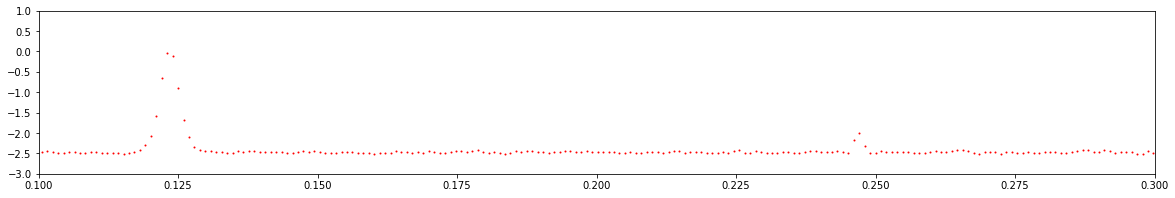

In [19]:
# Set window

w = Window(1024, name='cosine_window', order=1.0, dtype=dtype, device=device)
print(w)

# Set data

t = torch.linspace(0.0, len(w)-1.0, len(w), dtype=dtype, device=device)
data = torch.cos(2.0*numpy.pi*0.12345*t) + 1.0E-2*torch.cos(2.0*numpy.pi*2.0*0.12345*t)
data = torch.stack([data + 5.0E-2*torch.randn(len(w), dtype=dtype, device=device) for _ in range(128)])

# Set TbT

d = Data.from_data(w, data)
print(d)

# Apply window (note, window is applied to work)

d.window_remove_mean()
d.window_apply()

# Initialize Frequency instance

f = Frequency(d)
print(f)

# Compute frequencies
# self.frequency container is used for normalization of each signal spectrum

f('parabola')

# Compute mean spectrum
# Note, spectra are not recomputed, normalization and averaging is performed

grid, spectrum = f.compute_mean_spectrum(log=True)

# Plot mean spectrum

plt.figure(figsize=(20, 3))
plt.xlim(0.1, 0.3)
plt.ylim(-3.0, 1.0)
plt.scatter(grid.cpu().numpy(), spectrum.cpu().numpy(), s=1, c='r')
plt.show()

# Clean

del w
del d
del f
del grid, spectrum
if device != torch.device('cpu'):
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

# Example-18: Non-uniform sampling

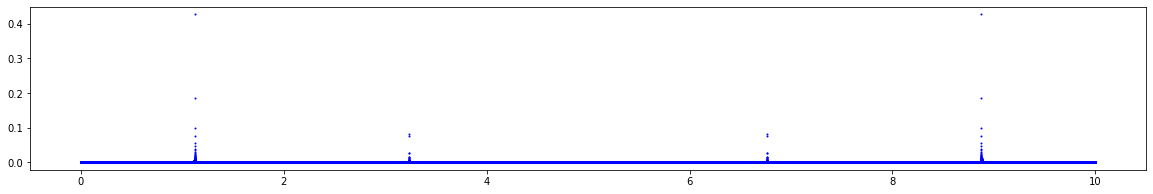

In [20]:
# Uniform sampling (stationary)

r = 10
l = 8192
t = torch.linspace(0.0, 1.0-1.0/r, r, dtype=torch.float64, device=torch.device('cpu'))
t = torch.cat([t + i for i in range(l)])

a = [1.0, 0.25]
f = [1.12345, 3.23456]
s = torch.sum(torch.stack([a[i]*torch.cos(2.0*numpy.pi*f[i]*t) for i in range(len(f))]), 0)

f_min, f_max = 0.0, 10.0
grid = 2.0*numpy.pi*numpy.linspace(f_min, f_max, len(t) + 1)
data = nufft.nufft1d3(t, s, grid)

plt.figure(figsize=(20, 3))
plt.scatter(grid/(2.0*numpy.pi), numpy.abs(data), c='b', s=1)
plt.show()

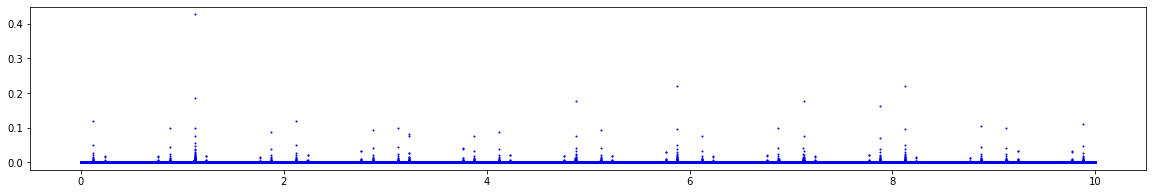

In [21]:
# Non-uniform periodic sampling (stationary)

r = 10
l = 8192
t = torch.sort(torch.rand(r, dtype=torch.float64, device=torch.device('cpu'))).values
t = torch.cat([t + i for i in range(l)])

a = [1.0, 0.25]
f = [1.12345, 3.23456]
s = torch.sum(torch.stack([a[i]*torch.cos(2.0*numpy.pi*f[i]*t) for i in range(len(f))]), 0)

f_min, f_max = 0.0, 10.0
grid = 2.0*numpy.pi*numpy.linspace(f_min, f_max, len(t) + 1)
data = nufft.nufft1d3(t, s, grid)

plt.figure(figsize=(20, 3))
plt.scatter(grid/(2.0*numpy.pi), numpy.abs(data), c='b', s=1)
plt.show()

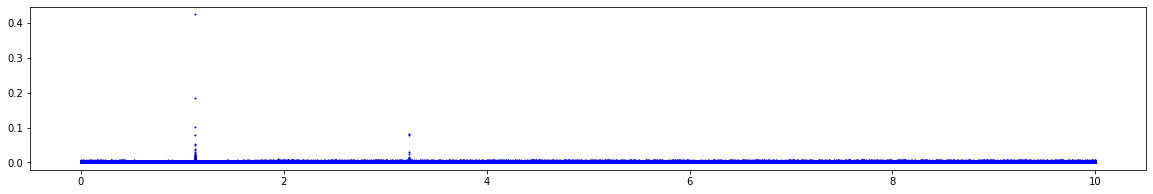

In [22]:
# Non-uniform random sampling (stationary)

r = 10
l = 8192
t = torch.cat([torch.sort(torch.rand(r, dtype=torch.float64, device=torch.device('cpu'))).values + i for i in range(l)])

a = [1.0, 0.25]
f = [1.12345, 3.23456]
s = torch.sum(torch.stack([a[i]*torch.cos(2.0*numpy.pi*f[i]*t) for i in range(len(f))]), 0)

f_min, f_max = 0.0, 10.0
grid = 2.0*numpy.pi*numpy.linspace(f_min, f_max, len(t) + 1)
data = nufft.nufft1d3(t, s, grid)

plt.figure(figsize=(20, 3))
plt.scatter(grid/(2.0*numpy.pi), numpy.abs(data), c='b', s=1)
plt.show()

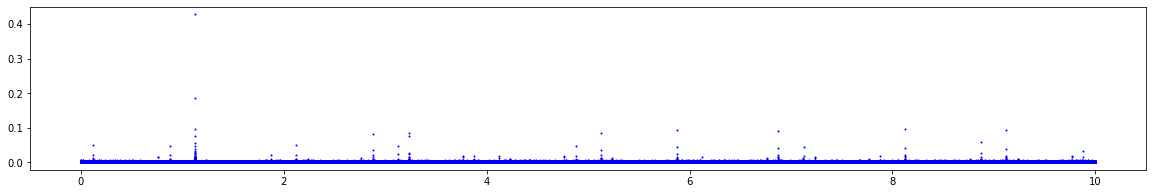

In [23]:
# Non-uniform periodic sampling with random choice (stationary)

c = 10
r = 5*10
l = 8192
t = torch.sort(torch.rand(r, dtype=torch.float64, device=torch.device('cpu'))).values
w = range(r)
t = torch.cat([torch.sort(t[numpy.random.choice(w, size=c, replace=False)]).values + i for i in range(l)])

a = [1.0, 0.25]
f = [1.12345, 3.23456]
s = torch.sum(torch.stack([a[i]*torch.cos(2.0*numpy.pi*f[i]*t) for i in range(len(f))]), 0)

f_min, f_max = 0.0, 10.0
grid = 2.0*numpy.pi*numpy.linspace(f_min, f_max, len(t) + 1)
data = nufft.nufft1d3(t, s, grid)

plt.figure(figsize=(20, 3))
plt.scatter(grid/(2.0*numpy.pi), numpy.abs(data), c='b', s=1)
plt.show()

# Example-19: Joined frequency (threshold)

In [24]:
# Set beta threshold

beta = 50.0

# Load model data

with open('../config.yaml', 'r') as stream:
    config = yaml.safe_load(stream)
    config = {key: config[key] for key in sorted(config.keys(), key=lambda name: config[name]['TIME'])}

# Set normalized positions (used as locations with NUFFT)

position = numpy.array([value['TIME'] for key, value in config.items() if value['TYPE'] == 'MONITOR' and value['BX'] <= beta])/LENGTH

# Set normalized accumulated phase advance between given monitor location and the next monitor location (used as locations with NUFFT)

phase = numpy.array([value['FX'] for key, value in config.items() if (value['TYPE'] == 'MONITOR' and value['BX'] <= beta) or key == 'TAIL'])
*_, tune = phase
phase = numpy.diff(phase)
phase = numpy.cumsum(phase)/tune
start, *_ = phase
phase = phase - start
tune = tune/(2.0*numpy.pi)

# Set window

w = Window(4096, name='cosine_window', order=2.0, dtype=dtype, device=device)
print(w)

# Load TbT data from file

d = Data.from_file(54, w, '../virtual_tbt.npy')
d = Data.from_data(w, torch.stack([signal for (signal, name) in zip(d, config) if config[name]['BX'] <= beta]))
print(d)

# Initialize Frequenshapeinstance

f = Frequency(d)
print(f)

# Compute reference frequency

d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
mean = 9.0 - torch.mean(f.frequency).item()
std = torch.std(f.frequency).item()
print(tune)
print(mean)
print(abs(mean-tune))
print(std)

# Compute mixed frequencies in given range

length = 128
f1 = f.compute_joined_frequency(length=length, f_range=(8.0,9.0), order=1.0, normalize=True)
f2 = f.compute_joined_frequency(length=length, f_range=(8.0,9.0), order=1.0, normalize=True, position=position)
f3 = f.compute_joined_frequency(length=length, f_range=(8.0,9.0), order=1.0, normalize=True, position=phase)
print(f1.cpu().numpy())
print(f2.cpu().numpy())
print(f3.cpu().numpy())
print((f1 - tune).abs().cpu().numpy())
print((f2 - tune).abs().cpu().numpy())
print((f3 - tune).abs().cpu().numpy())

# Clean

del w
del d
del f
del f1, f2, f3
if device != torch.device('cpu'):
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(4096, 'cosine_window', 2.0)
Data(52, Window(4096, 'cosine_window', 2.0))
Frequency(Data(52, Window(4096, 'cosine_window', 2.0)), f_range=(0.0, 0.5))
8.536883098737361
8.536883098737315
4.618527782440651e-14
3.3685495502282104e-16
[8.5390625  8.53688401 8.5368831 ]
[8.53688956 8.53688005 8.53688005]
[8.53688956 8.53688294 8.53688292]
[2.17940126e-03 9.15685716e-07 5.51684920e-10]
[6.45798691e-06 3.04775408e-06 3.05089194e-06]
[6.45798691e-06 1.57647554e-07 1.77992783e-07]


# Example-20: Uncertainty estimation with error propagation and fit

In [25]:
# Estimate frequency and amplitude uncertainty from multiple noise realizations

# Set parameters

length = 1024

# Set signal (harmonic signal with two components)

time = torch.linspace(1, length, length, dtype=dtype, device=device)
signal = 1.0*torch.cos(2.0*numpy.pi*0.12345*time) + 0.1*torch.cos(2.0*numpy.pi*2.0*0.12345*time)

# Set TbT (signal copies with different noise realizations)

std = 0.10
w = Window.from_cosine(length, 1.0, dtype=dtype, device=device)
data = torch.stack([signal + std*torch.randn(length, dtype=dtype, device=device) for _ in range(1024)])
d = Data.from_data(w, data)

# Remove mean and apply window

d.window_remove_mean()
d.window_apply()

# Estimate frequency

f = Frequency(d)
f('parabola')
m_f, s_f = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()

# Reset work

d.reset()

# Print result

print(f'frequency: error={abs(0.12345 - m_f):<16.12}, spread={s_f:<16.12}')

# Estimate amplitude

c = 2.0/w.total*torch.sum(torch.cos(2.0*numpy.pi*m_f*time)*d.data*w.window, 1)
s = 2.0/w.total*torch.sum(torch.sin(2.0*numpy.pi*m_f*time)*d.data*w.window, 1)
a = torch.sqrt(c*c + s*s)
m_a, s_a = a.mean().cpu().item(), a.std().cpu().item()

# Print result

print(f'amplitude: error={abs(1.0 - m_a):<16.12}, spread={s_a:<16.12}')

frequency: error=9.02203560471e-08, spread=3.84008646574e-06
amplitude: error=4.30874438784e-06, spread=0.00545489129988


In [26]:
# Estimate amplitude uncertainty from one signal using error propagation
# Noise sigma is assumed to be known
# Frequency uncertainty contribution (generaly small) is ignored here

# Amplitude

def get_amplitude(frequency, signal):
    c = 2.0/w.total*torch.sum(torch.cos(2.0*numpy.pi*frequency*time)*signal*w.window)
    s = 2.0/w.total*torch.sum(torch.sin(2.0*numpy.pi*frequency*time)*signal*w.window)
    return torch.sqrt(c*c + s*s)

# Set signal

signal = torch.zeros(length, dtype=dtype, device=device)
signal, *_ = d
get_amplitude(m_f, signal)
signal.requires_grad_(True)
signal.grad = None

# Set covariance matrix

m = std**2 + torch.zeros(length, dtype=dtype, device=device)
m = torch.diag(m)

# Compute amplitude and gradient

a = get_amplitude(m_f, signal)
a.backward()
g = signal.grad

# Compute and compare uncertainty estimation

print(s_a)
print(torch.sqrt(torch.dot(g, torch.matmul(m, g))).detach().cpu().item())

0.005454891299878464
0.005412658773651818


w_min/w_max = 0.9901585483240447


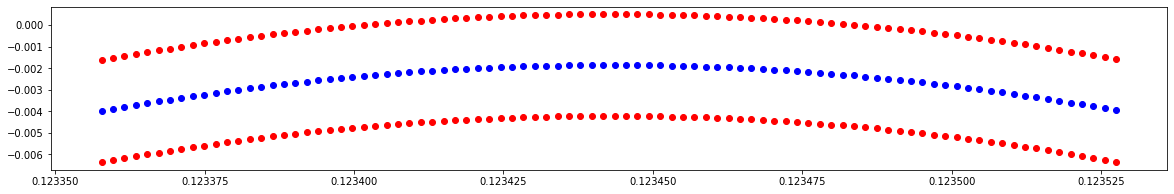

STD: 3.84008646574e-06
OLS: 2.75740783864e-06
WLS: 2.75740873805e-06


In [27]:
# Estimate frequency uncertainty from one signal using error propagation
# Noise sigma is assumed to be known if used
# For frequency, gradient can't be computed directry, since frequency estimation is an argmax problem
# In this case, for several frequencies near expected maximum location, corresponding DTFT amplitudes are computed
# A parabola can be then fitted and standart errors for coefficients can be estimated
# Error propagation can be used for each frequency value (or for minimum location), then (weighted) fit can be used
# In this example OLS and WLS are used from statsmodels library
# Note, such frequency uncertainty estimation might not br particularly accurate
# It depends on selected grid of frequencies
# Still, the order of magnitude can be somewhat meaningful

# Set a grid of frequencies near expected maximum
# Note, here ffrft grid is used for the 1st signal in TbT
# Here, grid points within given amplitude threshold

limit = 0.995
index, *_ = f.ffrft_bin.to(torch.int32)
data, *_ = f.ffrft_spectrum
grid = f.ffrft_get_grid()[limit*data[index] - data < 0]

# Set signal

signal = torch.zeros(length, dtype=dtype, device=device)
signal, *_ = d
signal.requires_grad_(True)

# Set covariance matrix

m = std**2 + torch.zeros(length, dtype=dtype, device=device)
m = torch.diag(m)

# Amplitude (log10)

def get_amplitude(frequency, signal):
    c = 2.0/w.total*torch.sum(torch.cos(2.0*numpy.pi*frequency*time)*signal*w.window)
    s = 2.0/w.total*torch.sum(torch.sin(2.0*numpy.pi*frequency*time)*signal*w.window)
    return torch.log10(torch.sqrt(c*c + s*s))

# Compute amplitude and weight for each frequency

X = []
y = []
weight = []
for frequency in grid:
    X.append([frequency.cpu().item()**2, frequency.cpu().item(), 1.0])
    a = get_amplitude(frequency, signal)
    a.backward()
    g = signal.grad
    y.append(a.cpu().item())
    weight.append(1/torch.dot(g, torch.matmul(m, g)).detach().cpu().item())
    signal.grad = None
    
# Note, weights are close to one, i.e. OLS and WLS should be close

print(f'w_min/w_max = {min(weight)/max(weight)}')

# Plot amplitudes

plt.figure(figsize=(20, 3))
plt.scatter(grid.cpu(), y - numpy.sqrt(1/numpy.array(weight)), color='red')
plt.scatter(grid.cpu(), y, color='blue')
plt.scatter(grid.cpu(), y + numpy.sqrt(1/numpy.array(weight)), color='red')
plt.show()

# Fit

from statsmodels.api import OLS, WLS
ols = OLS(y, X).fit()
wls = WLS(y, X, weights=numpy.array(weight)).fit()

# Print results

print(f'STD: {s_f:<16.12}')

a, b, c = ols.params
s_a, s_b, s_c = ols.bse
sigma = 1.0/(2.0*a**2)*numpy.sqrt(b**2*s_a**2+a**2*s_b**2)
print(f'OLS: {sigma:<16.12}')

a, b, c = wls.params
s_a, s_b, s_c = ols.bse
sigma = 1.0/(2.0*a**2)*numpy.sqrt(b**2*s_a**2+a**2*s_b**2)
print(f'WLS: {sigma:<16.12}')

# Note, this uncertainty estimation can be used to do weighted fit for different BPMs

In [28]:
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.005e+09
Date:                Tue, 14 Jun 2022   Prob (F-statistic):               0.00
Time:                        10:52:53   Log-Likelihood:                 1327.0
No. Observations:                  90   AIC:                            -2648.
Df Residuals:                      87   BIC:                            -2640.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -2.955e+05      4.667  -6.33e+04      0.0

In [29]:
print(wls.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.004e+09
Date:                Tue, 14 Jun 2022   Prob (F-statistic):               0.00
Time:                        10:52:55   Log-Likelihood:                 1327.1
No. Observations:                  90   AIC:                            -2648.
Df Residuals:                      87   BIC:                            -2641.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -2.955e+05      4.667  -6.33e+04      0.0

# Example-21: Generation and identification of harmonics

In [30]:
# For phase space of dimension 2N, quasiperiodic orbit contains N fundamental frequencies
# Other harmonics are combinations of this fundamental basis

# Generate harmonics (real signal with sampling rate equal to one)

order = 2
basis = [0.12, 0.31]
print()
for key, value in Frequency.harmonics(order, basis).items():
    print(key, value)
    
# Identify harmonics (for given basis and maximum order find closest harmonic)

order = 2
basis = [0.12, 0.31]
frequencies = Frequency.harmonics(order, basis).values()
print()
for key, value in Frequency.identify(order, basis, frequencies).items():
    print(key, value)


(0, 1) 0.31
(1, 0) 0.12
(0, 2) 0.38
(1, -1) 0.19
(1, 1) 0.43
(2, 0) 0.24

(0, 1) [0.31, 0.31, 0.0]
(1, 0) [0.12, 0.12, 0.0]
(0, 2) [0.38, 0.38, 0.0]
(1, -1) [0.19, 0.19, 0.0]
(1, 1) [0.43, 0.43, 0.0]
(2, 0) [0.24, 0.24, 0.0]


# Example-22: Fitted frequency (method)

In [31]:
# In this example frequency (and its spread) is estimated for each signal using OLS/WLS fit
# Fit for each signal is performed using DTFT spectrum points near the expected maximum
# This provides estimation of frequency and its spread for a signal
# Data across signals can be used to fit (optionaly with weights) overall frequency

# These estimations are compared with estimations from multiple noise realizations
# And with estimations from time shifted signals

In [32]:
# Compute reference frequency
# Note, without noise, frequencies for different BPMs are equal within machine precision (for given length and window)

# Set parameters (signal length, data type and device)

length = 4096

# Set window

w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

# Load TbT

d = Data.from_file(54, w, '../virtual_tbt.npy')

# Remove mean and apply window

d.window_remove_mean()
d.window_apply()

# Compute reference frequency

f = Frequency(d)
f('parabola')
m_ref, s_ref = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()

# Reset work

d.reset()

# Print results

print(f'{m_ref:<16.12}')
print(f'{s_ref:<16.12}')

0.463116901263  
1.22238738968e-16


In [33]:
# Set noise parameters

# All BPMs have different noise sigma

std = 1.0E-4*(4.0*torch.rand(54) + 1.0)

# One BPM has increased noise level

std[0] = 3.0E-3

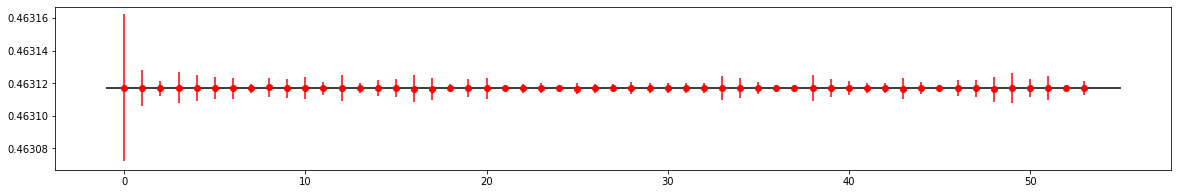

In [34]:
# Estimate spread for different noise realizations

# Iterate over noise realizations

table = []
count = 1024

for _ in range(count):
    w = Window(1024, 'cosine_window', 1.0, dtype=dtype, device=device)
    t = Data.from_data(w, d.data[:, :len(w)])
    t.add_noise(std)
    t.window_remove_mean()
    t.window_apply()
    f = Frequency(t)
    f('parabola')
    table.append(f.frequency)
    
table = torch.stack(table)

# Set mean and spread values for each BPM

m1, s1 = table.mean(0).cpu(), table.std(0).cpu()

# Plot results

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), m1, yerr=s1, c='red', fmt='o')
plt.ylim((m_ref - 5.0E-5, m_ref + 5.0E-5))
plt.hlines(m_ref, -1, 55, colors='black')
plt.show()

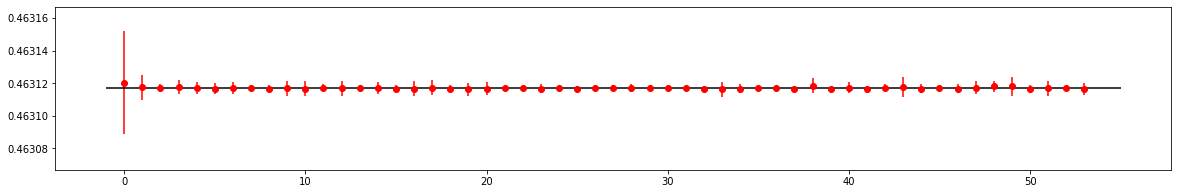

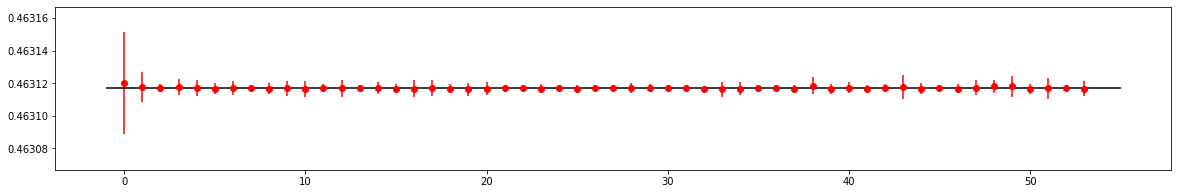

In [35]:
# Estimate spread from time shifted signals

# Load data

w = Window(length, dtype=dtype, device=device)
d = Data.from_file(54, w, '../virtual_tbt.npy')
d.add_noise(std)

# Iterate over signals

table = []

w = Window(1024, dtype=dtype, device=device)
for idx in range(d.size):
    t = d.make_matrix(length=w.length, shift=16, signal=d.work[idx])
    t = Data.from_data(w, t)
    t.window_remove_mean()
    t.window_apply()
    f = Frequency(t)
    f('parabola')
    table.append(f.frequency)
    
table = torch.stack(table)

# Set mean and spread values for each BPM
# Note, spread is computed as std

m2, s2 = table.mean(1).cpu(), table.std(1).cpu()

# Plot results

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), m2, yerr=s2, c='red', fmt='o')
plt.ylim((m_ref - 5.0E-5, m_ref + 5.0E-5))
plt.hlines(m_ref, -1, 55, colors='black')
plt.show()

# Set mean and spread values for each BPM
# Note, spread is computed from  peak-to-peak

f_min = table.min(1).values
f_max = table.max(1).values

m2 = table.mean(1).cpu()
s2 = 1/4.0*(f_max - f_min).cpu()

# Plot results

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), m2, yerr=s2, c='red', fmt='o')
plt.ylim((m_ref - 5.0E-5, m_ref + 5.0E-5))
plt.hlines(m_ref, -1, 55, colors='black')
plt.show()

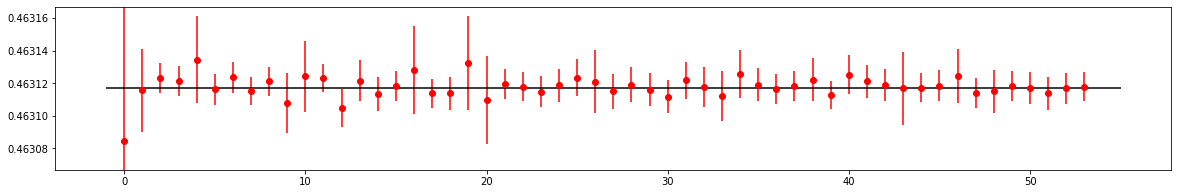

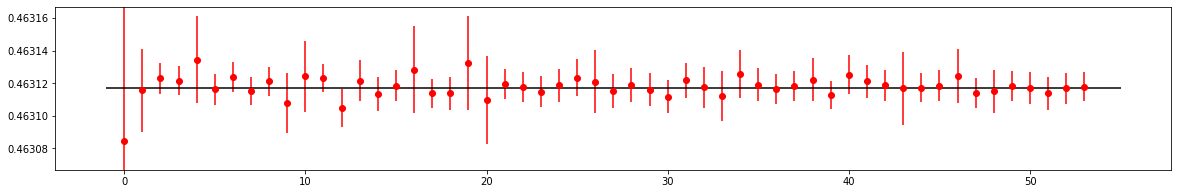

In [36]:
# Estimate spread from fit

# Load data

w = Window(1024, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_file(54, w, '../virtual_tbt.npy')
d.add_noise(std)

# Remove mean and apply window

d.window_remove_mean()
d.window_apply()

# Compute frequencies

f = Frequency(d)
f('parabola')

# Fit (ols)

out = f.compute_fitted_frequency(fraction=0.995, mode='ols')

# Set fitted frequencies and spread

m3, s3 = out.T.cpu()

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), m3, yerr=s3, c='red', fmt='o')
plt.ylim((m_ref - 5.0E-5, m_ref + 5.0E-5))
plt.hlines(m_ref, -1, 55, colors='black')
plt.show()

# Fit (wls)

out = f.compute_fitted_frequency(fraction=0.995, mode='wls', std=std)

# Set fitted frequencies and spread

m3, s3 = out.T.cpu()

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), m3, yerr=s3, c='red', fmt='o')
plt.ylim((m_ref - 5.0E-5, m_ref + 5.0E-5))
plt.hlines(m_ref, -1, 55, colors='black')
plt.show()

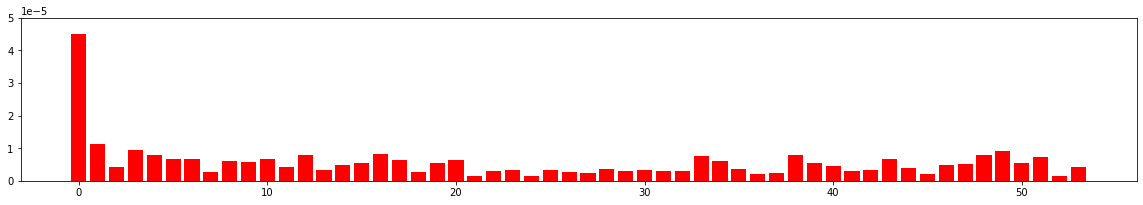

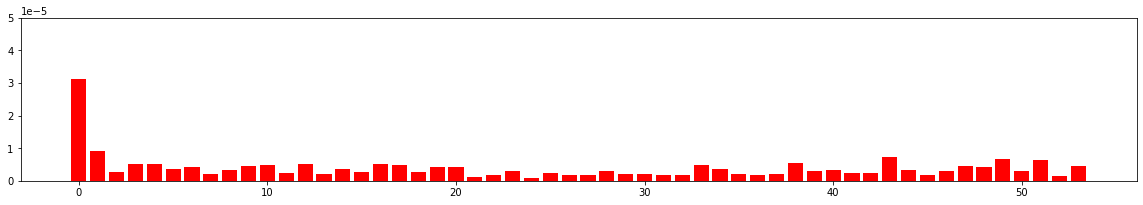

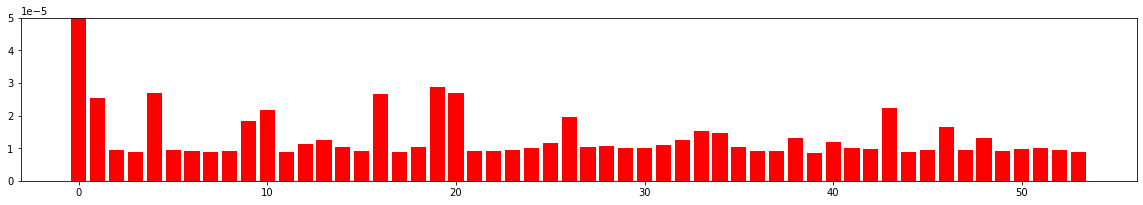

In [37]:
# Compare

plt.figure(figsize=(20, 3))
plt.bar(range(54), s1, color='red')
plt.ylim((0, 5.0E-5))
plt.show()

plt.figure(figsize=(20, 3))
plt.bar(range(54), s2, color='red')
plt.ylim((0, 5.0E-5))
plt.show()

plt.figure(figsize=(20, 3))
plt.bar(range(54), s3, color='red')
plt.ylim((0, 5.0E-5))
plt.show()

In [38]:
# Compare direct mean

print(abs(m_ref - m1.mean().cpu().item()))
print(abs(m_ref - m2.mean().cpu().item()))
print(abs(m_ref - m3.mean().cpu().item()))

4.397170105807646e-08
1.0676536082998567e-07
9.680302845427313e-07


In [39]:
# Fit frequency for all BPMs

from statsmodels.api import OLS, WLS

X = numpy.ones(54).reshape(1, 54).T
y = m1.numpy()
w = (1/s1**2).cpu().numpy()

ols1 = OLS(y, X).fit()
wls1 = WLS(y, X, w).fit()

print(f'ols: err={abs(m_ref - ols1.params.item()):12.8}, std={ols1.bse.item():12.8}')
print(f'wls: err={abs(m_ref - wls1.params.item()):12.8}, std={wls1.bse.item():12.8}')

ols: err=4.3971701e-08, std=2.6160721e-08
wls: err=1.1139976e-08, std=1.5150554e-08


In [40]:
# Fit frequency for all BPMs using 'shifted' weights

from statsmodels.api import OLS, WLS

X = numpy.ones(54).reshape(1, 54).T
y = m2.numpy()
w = (1/s2**2).cpu().numpy()

ols2 = OLS(y, X).fit()
wls2 = WLS(y, X, w).fit()

print(f'ols: err={abs(m_ref - ols2.params.item()):12.8}, std={ols2.bse.item():12.8}')
print(f'wls: err={abs(m_ref - wls2.params.item()):12.8}, std={wls2.bse.item():12.8}')

ols: err=1.0676536e-07, std=8.6373798e-08
wls: err=2.0205398e-09, std=3.9710175e-08


In [41]:
# Fit frequency for all BPMs using 'fitted' weights

from statsmodels.api import OLS, WLS

X = numpy.ones(54).reshape(1, 54).T
y = m3.numpy()
w = (1/s3**2).cpu().numpy()

ols3 = OLS(y, X).fit()
wls3 = WLS(y, X, w).fit()

print(f'ols: err={abs(m_ref - ols3.params.item()):12.8}, std={ols3.bse.item():12.8}')
print(f'wls: err={abs(m_ref - wls3.params.item()):12.8}, std={wls3.bse.item():12.8}')

ols: err=9.6803028e-07, std=9.7029792e-07
wls: err=9.6054274e-07, std=5.6918237e-07


# Example-23: Envelope and instantaneous frequency

In [42]:
# In this example DHT is used to compute signal envelope and instantaneous frequency

In [43]:
# Set test signal

length = 8192

t = torch.linspace(1, length, length, dtype=dtype, device=device)
s = torch.exp(-0.0001*t*(1 + 0.25*torch.cos(2*numpy.pi*0.001*t)))*torch.cos(2.0*numpy.pi*0.12345*t).unsqueeze(0)

# Compute DHT

dht = Frequency.dht(s)

# Compute envelope

envelope = dht.abs()

# Compute instantaneous frequency
# Note, length is reduced by one

frequency = 1/(2.0*numpy.pi)*(dht[:, :-1]*dht[:, 1:].conj()).angle()

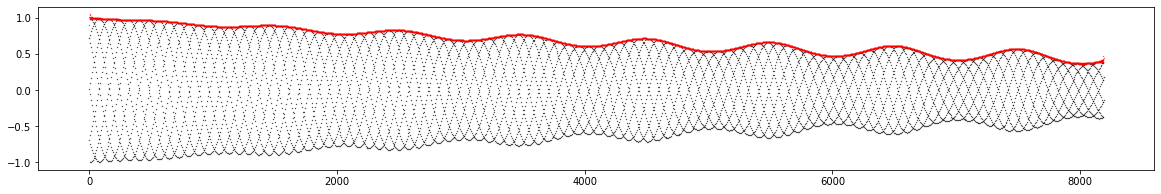

In [44]:
# Plot signal and envelope
# Note, result is not accurate at both ends

plt.figure(figsize=(20 ,3))
plt.scatter(range(length), s[0].cpu().numpy(), c='black', s=0.1)
plt.scatter(range(length), envelope[0].cpu().numpy(), c='red', s=0.1)
plt.show()

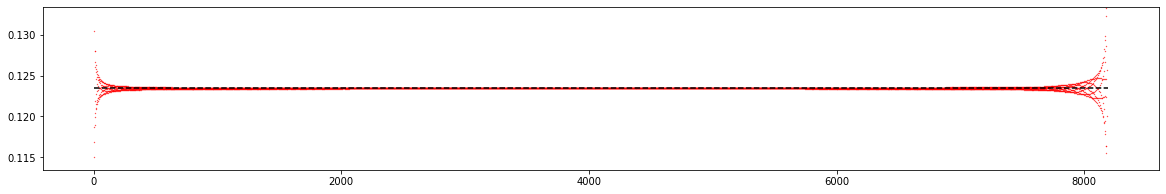

In [45]:
# Plot instantaneous frequency
# Note, result is not accurate at both ends

plt.figure(figsize=(20, 3))
plt.ylim(0.12345-0.01, 0.12345+0.01)
plt.scatter(range(length-1), frequency[0].cpu().numpy(), c='red', s=0.1)
plt.hlines(0.12345, 1, length, color='black', linestyles='dashed')
plt.show()

# Example-24: Autocorrelation

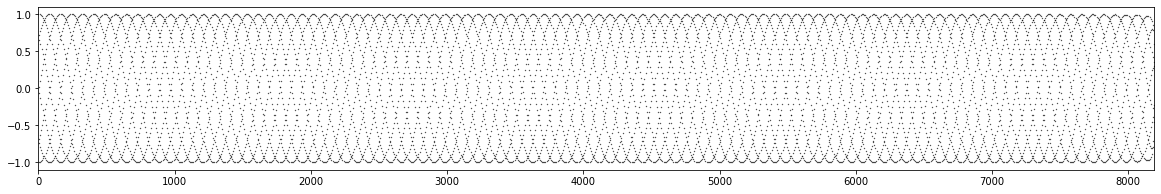

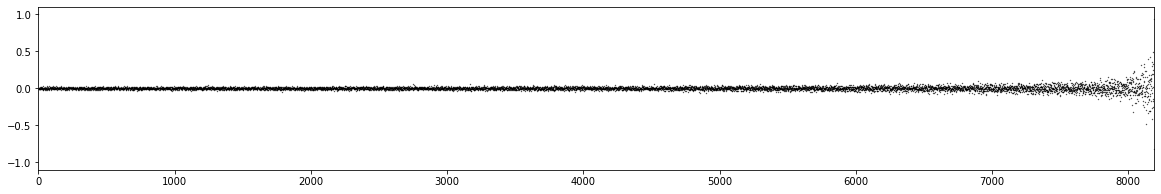

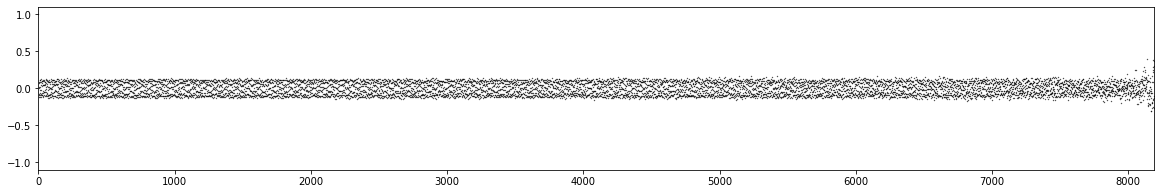

In [46]:
# Compute autocorrelation for harmonic, random noise and 'hidden' harmonic with noise

length = 8192

s = torch.cos(2.0*numpy.pi*0.12345*torch.linspace(1, length, length, dtype=dtype, device=device)).unsqueeze(0)
auto1 = Frequency.autocorrelation(s)
plt.figure(figsize=(20, 3))
plt.scatter(range(length), auto1[0].cpu().numpy(), c='black', s=0.1)
plt.xlim(0, length + 1)
plt.ylim(-1.1, 1.1)
plt.show()

s = torch.randn((1, length), dtype=dtype, device=device)
auto2 = Frequency.autocorrelation(s)
plt.figure(figsize=(20, 3))
plt.scatter(range(length), auto2[0].cpu().numpy(), c='black', s=0.1)
plt.xlim(0, length + 1)
plt.ylim(-1.1, 1.1)
plt.show()

s = 0.5*torch.cos(2.0*numpy.pi*0.12345*torch.linspace(1, length, length, dtype=dtype, device=device)).unsqueeze(0)
s += torch.randn((1, length), dtype=dtype, device=device)
auto3 = Frequency.autocorrelation(s)
plt.figure(figsize=(20, 3))
plt.scatter(range(length), auto3[0].cpu().numpy(), c='black', s=0.1)
plt.xlim(0, length + 1)
plt.ylim(-1.1, 1.1)
plt.show()

[0.12345006 0.45115911 0.12345393]


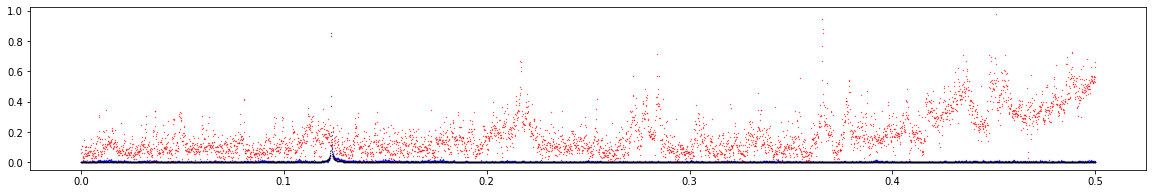

In [47]:
# Examine autocorrelation spectrum

w = Window.from_cosine(length, 0.0, dtype=dtype, device=device)
d = Data.from_data(w, torch.cat([auto1, auto2, auto3]))
d.window_remove_mean()
d.window_apply()
f = Frequency(d)
f('parabola')
print(f.frequency.cpu().numpy())

plt.figure(figsize=(20, 3))
plt.scatter(f.fft_grid.cpu().numpy(), (f.fft_spectrum[2]/f.ffrft_spectrum[2].max()).cpu().numpy(), color='blue', s=0.1)
plt.scatter(f.fft_grid.cpu().numpy(), (f.fft_spectrum[1]/f.ffrft_spectrum[1].max()).cpu().numpy(), color='red', s=0.1)
plt.scatter(f.fft_grid.cpu().numpy(), (f.fft_spectrum[0]/f.ffrft_spectrum[0].max()).cpu().numpy(), color='black', s=0.1)
plt.show()

# Example-25: Frequency from shifted signals (method)

In [48]:
# Set parameters

size, length = 2, 2**15

# Set window

w = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)

# Set TbT

t = torch.linspace(1, length, length, dtype=dtype, device=device)
x = 0.75*torch.cos(2.0*numpy.pi*0.12*t + 0.10)
y = 0.50*torch.cos(2.0*numpy.pi*0.31*t + 0.50)
d = Data.from_data(w, torch.stack([x, y]))

# Add noise

d.add_noise(torch.tensor([1.0E-2, 1.0E-4], dtype=dtype, device=device))

# Estimate frequency from shifted signals
# Note, work is used in task_shift(), window is applied inside

f = Frequency(d)
out = f.compute_shifted_frequency(1024, 8)
print(out.shape)

torch.Size([2, 3969])


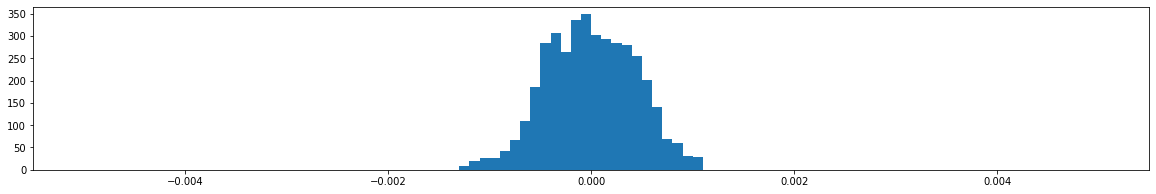

tensor(2.751220782513e-06, dtype=torch.float64)


In [49]:
# Plot result (1st signal)

plt.figure(figsize=(20, 3))
plt.hist((out[0].cpu().numpy()-0.12)/0.12 * 100, bins=100, range=(-0.005, 0.005))
plt.show()
print(out[0].max() - out[0].min())

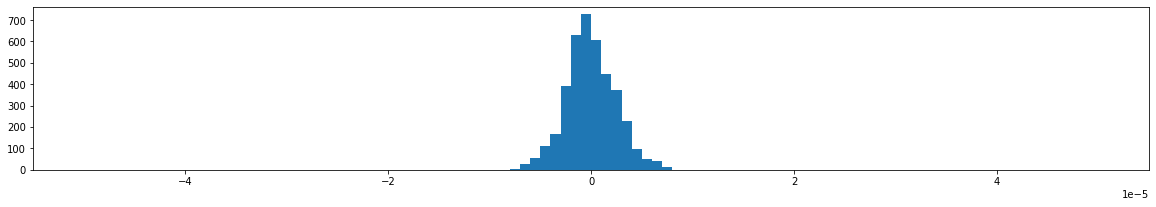

tensor(4.577540185791e-08, dtype=torch.float64)


In [50]:
# Plot result (2nd signal)

plt.figure(figsize=(20, 3))
plt.hist((out[1].cpu().numpy()-0.31)/0.31 * 100, bins=100, range=(-0.00005, 0.00005))
plt.show()
print(out[1].max() - out[1].min())

# Example-26: Frequency estimation from complex data

In [51]:
# TbT data can be complex, in this case data type should be passed for Data(), Data.from_file() and Data.from_epics

# f < 1/2

w = Window.from_cosine(4096, 1.0, dtype=torch.float64, device=device)
c = torch.cos(2.0*numpy.pi*0.12*torch.linspace(1, w.length, w.length, dtype=torch.complex128, device=device))
s = torch.sin(2.0*numpy.pi*0.12*torch.linspace(1, w.length, w.length, dtype=torch.complex128, device=device))
d = torch.stack([c + 1j*s])
d = Data.from_data(w, d)
d.window_apply()
f = Frequency(d, f_range=(0.0, 1.0))
f('parabola')
print(f.frequency)

# f > 1/2

w = Window.from_cosine(4096, 1.0, dtype=torch.float64, device=device)
c = torch.cos(2.0*numpy.pi*0.88*torch.linspace(1, w.length, w.length, dtype=torch.complex128, device=device))
s = torch.sin(2.0*numpy.pi*0.88*torch.linspace(1, w.length, w.length, dtype=torch.complex128, device=device))
d = torch.stack([c + 1j*s])
d = Data.from_data(w, d)
d.window_apply()
f = Frequency(d, f_range=(0.0, 1.0))
f('parabola')
print(f.frequency)

tensor([1.200000000000e-01], dtype=torch.float64)
tensor([8.800000000000e-01], dtype=torch.float64)


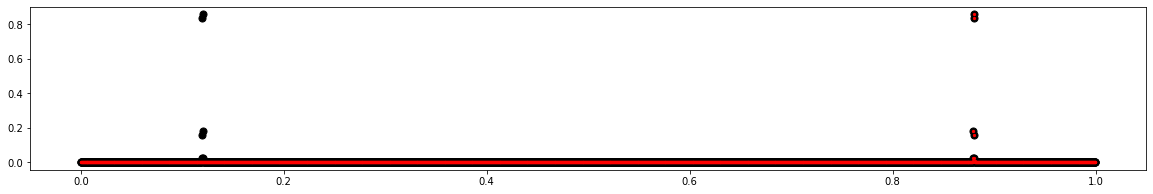

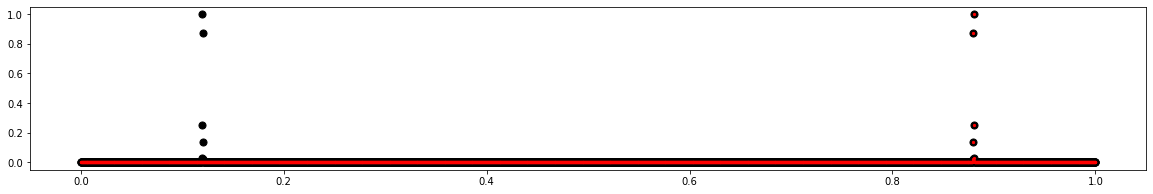

In [52]:
# Compare amplitude spectrum for real and complex data
# Note, correct iflag for nufft is -1 for complex data

# Real signal (FFT and NUFFT)

w = Window.from_cosine(4096, 1.0, dtype=torch.float64, device=device)
c = torch.cos(2.0*numpy.pi*0.88*torch.linspace(1, w.length, w.length, dtype=torch.complex128, device=device))
s = torch.sin(2.0*numpy.pi*0.88*torch.linspace(1, w.length, w.length, dtype=torch.complex128, device=device))
d = torch.stack([c])
d = Data.from_data(w, d)
d.window_apply()
f1 = Frequency(d, f_range=(0.0, 1.0))
f1('parabola')
d.reset()
g1, s1 = f1.compute_joined_spectrum(length=w.length, f_range=(0.0, 1.0), position=numpy.array([1.0]), iflag=-1)

# Complex signal (FFT and NUFFT)

w = Window.from_cosine(4096, 1.0, dtype=torch.float64, device=device)
c = torch.cos(2.0*numpy.pi*0.88*torch.linspace(1, w.length, w.length, dtype=torch.complex128, device=device))
s = torch.sin(2.0*numpy.pi*0.88*torch.linspace(1, w.length, w.length, dtype=torch.complex128, device=device))
d = torch.stack([c + 1j*s])
d = Data.from_data(w, d)
d.window_apply()
f2 = Frequency(d, f_range=(0.0, 1.0))
f2('parabola')
d.reset()
g2, s2 = f2.compute_joined_spectrum(length=w.length, f_range=(0.0, 1.0), position=numpy.array([1.0]), iflag=-1)

# Plot results (FFT spectum)

plt.figure(figsize=(20, 3))
plt.scatter(f1.fft_grid.cpu().numpy(), (f1.fft_spectrum[0]/f1.ffrft_spectrum[0].max()).cpu().numpy(), s=50.0, color='black')
plt.scatter(f2.fft_grid.cpu().numpy(), (f2.fft_spectrum[0]/f2.ffrft_spectrum[0].max()).cpu().numpy(), s=05.0, color='red')
plt.show()

# Plot results (NUFFT spectum)

plt.figure(figsize=(20, 3))
plt.scatter(g1.real.cpu().numpy(), s1.real.cpu().numpy(), s=50.0, color='black')
plt.scatter(g2.real.cpu().numpy(), s2.real.cpu().numpy(), s=05.0, color='red')
plt.show()

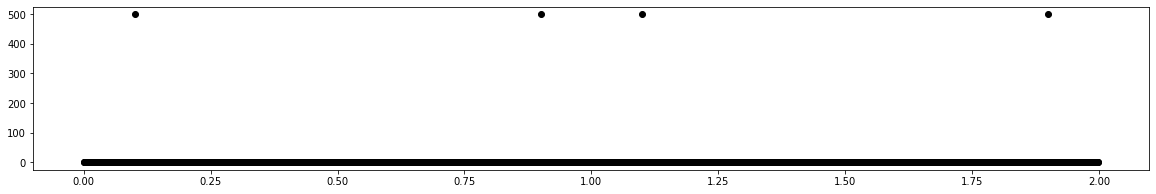

In [53]:
# Insert zeros

length = 1000
signal = torch.cos(2.0*numpy.pi*0.1*torch.linspace(1, length, length, dtype=torch.complex128, device=device))

insert = 1

mask = torch.zeros(1 + insert, dtype=torch.float64, device=device)
mask[0] = 1.0

signal = (mask*signal.reshape(-1, 1)).flatten().reshape(1, -1)

w = Window.from_cosine(length*(1 + insert), 0.0, dtype=torch.float64, device=device)
d = Data.from_data(w, signal)
d.window_apply()
f = Frequency(d)
f('fft')

plt.figure(figsize=(20, 3))
plt.scatter(f.fft_grid.cpu().numpy()*(1 + insert), f.fft_spectrum[0].cpu().numpy(), color='black')
plt.show()

# Example-27: Frequency loop

In [1]:
# In this example the main frequency is estimated using different methods
# In all cases window is used and no data filtering is performed (anomaly detection or noise filtering)
# Full signal length is 1024 turns

In [2]:
# Test cases:

# 1. Estimate the main frequency for each signal using 'parabola' interpolation of refined amplitude spectrum
#    Estimate frequency as mean over signals and spread as standard deviation
#    Estimate frequency with OLS fit and spread as OLS standard error

# 2. Estimate the main frequency for each signal using 'parabola' interpolation of refined amplitude spectrum
#    Estimate noise for each signal using optimal SVD and use it in WLS
#    Note, SNR can be used as weights

# 3. Estimate the main frequency for each signal using 'parabola' interpolation of refined amplitude spectrum
#    Estimate standard error for each signal using OLS or WLS (use noise for weighting)
#    Perform WLS fit for the main frequency and its spread

# 4. Estimate the main frequency for sampled signals using 'parabola' interpolation of refined amplitude spectrum
#    Estimate spread for each signal using standard deviation in sample frequencies
#    Perform WLS fit for the main frequency and its spread

# 5. Estimate the main frequency for sampled signals using 'parabola' interpolation of refined amplitude spectrum
#    Estimate noise for each sample, WLS fit to estimate sample spread
#    WLS fit samples to estimate the signal frequency and its spread
#    WLS fit signals to estimate the main frequency and its spread

In [3]:
# Import

import epics
import numpy
import pandas
import torch
import nufft

import sys
sys.path.append('..')

from harmonica.util import LENGTH
from harmonica.statistics import weighted_mean, weighted_variance
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter

from statsmodels.api import OLS, WLS

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())
print(torch.get_num_threads())

True
6


In [4]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [5]:
# Reference case

# Set parameters

length = 1024

# Set window

w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)

# Load TbT

d = Data.from_file(54, w, '../virtual_tbt.npy')

# Remove mean and apply window

d.window_remove_mean()
d.window_apply()

# Compute reference frequency

f = Frequency(d)
f('parabola')
f_ref, s_ref = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()

# Reset work

d.reset()

# Print results

print(f'{f_ref:<16.9}')
print(f'{s_ref:<16.9}')

0.463116901     
2.30523602e-16  


In [6]:
# Set data with noise

# Generate noise sigma for each signal

std = 1.0E-6*(25.0 + 75.0*torch.rand(54, dtype=dtype, device=device))

# Set test data

d.reset()
d.add_noise(std)
data = d.work
print(data.shape)

# Set spike

data[1, 128] += 0.5
data[1, 256] -= 0.5

torch.Size([54, 1024])


In [7]:
# Estimate the main frequency for each signal using 'parabola' interpolation of refined amplitude spectrum
# Estimate frequency as mean over signal and spread as standard deviation
# Estimate frequency with OLS fit and spread as OLS standard error

# Set data

w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
t = Data.from_data(w, data)

# Estimate frequency

t.window_remove_mean()
t.window_apply()
f = Frequency(t)
f('parabola')
t.reset()

# Estimate the main frequency and its spread using mean and standard deviation

f_out = f.frequency.mean().cpu().item()
s_out = f.frequency.std().cpu().item()
f_1, s_1 = f_out, s_out
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

# Estimate the main frequency and its spread using OLS fit

x = numpy.ones((54, 1))
y = f.frequency.cpu().numpy()
out = OLS(y, x).fit()
f_out = out.params.item()
s_out = out.bse.item()
f_2, s_2 = f_out, s_out
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

err: 3.54722049e-06  , std: 2.19499213e-05  
err: 3.54722049e-06  , std: 2.98700595e-06  


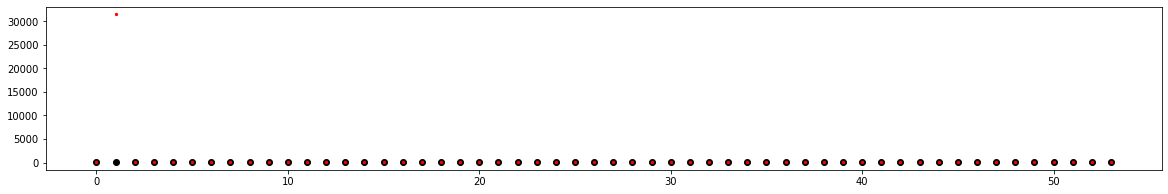

err: 3.11535079e-07  , std: 1.16947498e-07  


In [8]:
# Estimate the main frequency for each signal using 'parabola' interpolation of refined amplitude spectrum
# Estimate noise for each signal using optimal SVD and use it in WLS fit as weight

# Set data

w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
t = Data.from_data(w, data)

# Estimate frequency

t.window_remove_mean()
t.window_apply()
f = Frequency(t)
f('parabola')
t.reset()

# Estimate noise

l = Filter(t)
_, s = l.estimate_noise(limit=32)

# Plot estimated noise and true noise

plt.figure(figsize=(20, 3))
plt.scatter(range(54), std.cpu()*1.0E+6, color='black')
plt.scatter(range(54), s.cpu()*1.0E+6, color='red', s=5)
plt.show()

# Estimate the main frequency and its spread using WLS fit

x = numpy.ones((54, 1))
y = f.frequency.cpu().numpy()
w = (1/s**2).cpu().numpy()
out = WLS(y, x, w).fit()
f_out = out.params.item()
s_out = out.bse.item()
f_3, s_3 = f_out, s_out
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

In [9]:
# Use weighted mean and variance estimation

# Use estimated noise for weighting

weight = 1/s**2
print(f'err: {abs(weighted_mean(f.frequency, weight=weight).cpu().item() - f_ref):<16.9}, std: {weighted_variance(f.frequency, weight=weight).sqrt().cpu().item():<16.9}')

# Use SNR for weighting

weight = 1/s**2*torch.stack([spectrum[index] for index, spectrum in zip(f.ffrft_bin.to(torch.int64), f.ffrft_spectrum)])**2
print(f'err: {abs(weighted_mean(f.frequency, weight=weight).cpu().item() - f_ref):<16.9}, std: {weighted_variance(f.frequency, weight=weight).sqrt().cpu().item():<16.9}')

err: 3.11535079e-07  , std: 8.67128486e-07  
err: 2.01902658e-07  , std: 7.47527362e-07  


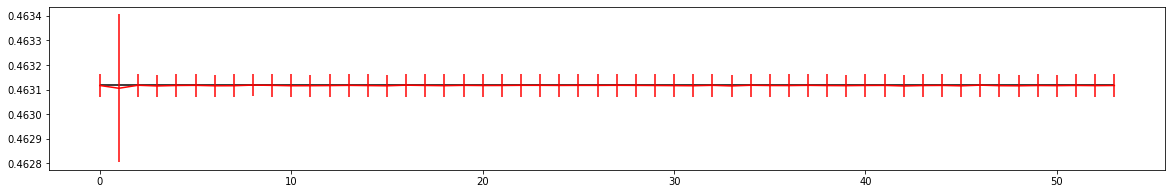

err: 1.94242883e-07  , std: 1.17407051e-07  


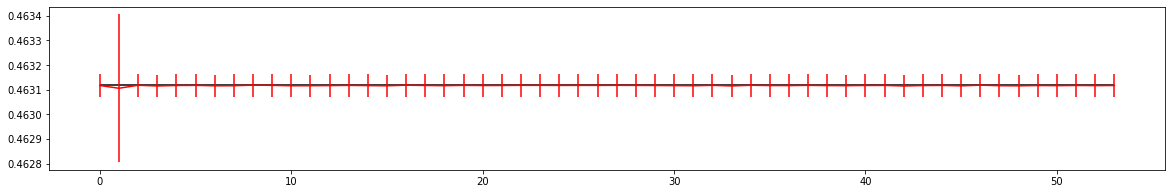

err: 1.9423843e-07   , std: 1.17399968e-07  


In [10]:
# Estimate the main frequency for each signal using 'parabola' interpolation of refined amplitude spectrum
# Estimate standard error for each signal using OLS/WLS
# Perform WLS fit for the main frequency and its spread

# Set data

w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
t = Data.from_data(w, data)

# Estimate frequency

t.window_remove_mean()
t.window_apply()
f = Frequency(t)
f('parabola')
t.reset()

# Estimate noise

l = Filter(t)
_, s = l.estimate_noise(limit=32)

# OLS

f_out, s_out = f.compute_fitted_frequency(mode='ols').T
plt.figure(figsize=(20, 3))
plt.hlines(f_ref, 0, 53, color='black')
plt.errorbar(range(54), f_out.cpu().numpy(), yerr=s_out.cpu().numpy(), color='red')
plt.show()
x = numpy.ones((54, 1))
y = f_out.cpu().numpy()
w = (1/s_out**2).cpu().numpy()
out = WLS(y, x, w).fit()
f_out = out.params.item()
s_out = out.bse.item()
f_4, s_4 = f_out, s_out
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

# WLS

f_out, s_out = f.compute_fitted_frequency(mode='wls', std=s).T
plt.figure(figsize=(20, 3))
plt.hlines(f_ref, 0, 53, color='black')
plt.errorbar(range(54), f_out.cpu().numpy(), yerr=s_out.cpu().numpy(), color='red')
plt.show()
x = numpy.ones((54, 1))
y = f_out.cpu().numpy()
w = (1/s_out**2).cpu().numpy()
out = WLS(y, x, w).fit()
f_out = out.params.item()
s_out = out.bse.item()
f_5, s_5 = f_out, s_out
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

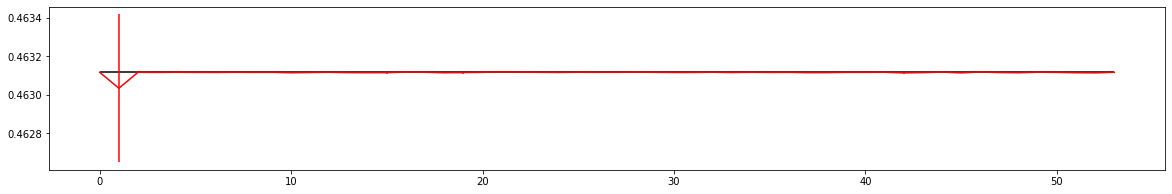

err: 2.86424606e-07  , std: 1.18075989e-07  


In [11]:
# Estimate the main frequency for sampled signals using 'parabola' interpolation of refined amplitude spectrum
# Estimate spread for each signal using standard deviation in sample frequencies
# Perform WLS fit for the main frequency and its spread

# Set data

w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
t = Data.from_data(w, data)

# Estimate frequency

t.window_remove_mean()
t.window_apply()
f = Frequency(t)
f('parabola')
t.reset()

# Estimated frequency for sampled data

out = f.compute_shifted_frequency(512, 8)
f_out = out.mean(1)
s_out = out.std(1)
plt.figure(figsize=(20, 3))
plt.hlines(f_ref, 0, 53, color='black')
plt.errorbar(range(54), f_out.cpu().numpy(), yerr=s_out.cpu().numpy(), color='red')
plt.show()

# WLS fit

x = numpy.ones((54, 1))
y = f_out.cpu().numpy()
w = (1/s_out**2).cpu().numpy()
out = WLS(y, x, w).fit()
f_out = out.params.item()
s_out = out.bse.item()
f_6, s_6 = f_out, s_out
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

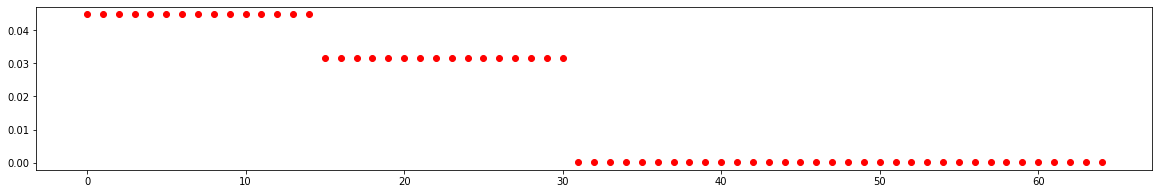

err: 2.92119427e-07  , std: 1.17781861e-07  


In [12]:
# Estimate the main frequency for sampled signals using 'parabola' interpolation of refined amplitude spectrum
# Estimate noise for each sample, WLS fit to estimate sample spread
# WLS fit samples to estimate signal frequency and its spread
# WLS fit signals to estimate the main frequency and its spread

# Set data

w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
t = Data.from_data(w, data)

# Sample data

w = Window(512, 'cosine_window', 1.0, dtype=dtype, device=device)
t = Data.from_data(w, torch.cat([t.make_matrix(512, 8, t.work[i]) for i in range(54)]))
n = t.size//54

# Estimate noise for all samples

l = Filter(t)
_, s = l.estimate_noise(limit=32)

# Plot noise estimation for signal with spike

plt.figure(figsize=(20, 3))
plt.scatter(range(n), s.cpu().reshape(54, -1)[1], color='red')
plt.show()

# Estimate frequency for each sample

t.window_remove_mean()
t.window_apply()
f = Frequency(t)
f('parabola')
t.reset()

# WLS fit samples

f_out = f.frequency.reshape(54, -1)
s_out = s.reshape(54, -1)
table = []
for i in range(54):
    x = numpy.ones((n, 1))
    y = f_out[i].cpu().numpy()
    w = (1/s_out[i]**2).cpu().numpy()
    out = WLS(y, x, w).fit()
    table.append([out.params.item(), out.bse.item()])
    
f_out, s_out = numpy.array(table).T

# WLS fit signals

x = numpy.ones((54, 1))
y = f_out
w = (1/s_out**2)
out = WLS(y, x, w).fit()
f_out = out.params.item()
s_out = out.bse.item()
f_7, s_7 = f_out, s_out
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

In [13]:
# Compare results

# 1 -- mean & std over signals
# 2 -- OLS fit over signals
# 3 -- WLS fit over signals using estimated noise as weight
# 4 -- OLS fit for signal, WLS fit over signals
# 5 -- WLS fit for signal, WLS fit over signals
# 6 -- mean & std over samples, WLS fit over signals
# 7 -- WLS fit over samples, WLS fit over signals

print(f'case: 1, err: {abs(f_1 - f_ref):<16.9}, std: {s_1:<16.9}')
print(f'case: 2, err: {abs(f_2 - f_ref):<16.9}, std: {s_2:<16.9}')
print(f'case: 3, err: {abs(f_3 - f_ref):<16.9}, std: {s_3:<16.9}')
print(f'case: 4, err: {abs(f_4 - f_ref):<16.9}, std: {s_4:<16.9}')
print(f'case: 5, err: {abs(f_5 - f_ref):<16.9}, std: {s_5:<16.9}')
print(f'case: 6, err: {abs(f_6 - f_ref):<16.9}, std: {s_6:<16.9}')
print(f'case: 7, err: {abs(f_7 - f_ref):<16.9}, std: {s_7:<16.9}')

case: 1, err: 3.54722049e-06  , std: 2.19499213e-05  
case: 2, err: 3.54722049e-06  , std: 2.98700595e-06  
case: 3, err: 3.11535079e-07  , std: 1.16947498e-07  
case: 4, err: 1.94242883e-07  , std: 1.17407051e-07  
case: 5, err: 1.9423843e-07   , std: 1.17399968e-07  
case: 6, err: 2.86424606e-07  , std: 1.18075989e-07  
case: 7, err: 2.92119427e-07  , std: 1.17781861e-07  


In [14]:
# Weighted mean & variance

# Do over samples
# Gives more realistic error estimation

amplitude = torch.stack([spectrum[index] for index, spectrum in zip(f.ffrft_bin.to(torch.int64), f.ffrft_spectrum)])**2

f_out = f.frequency
s_out = s

center = weighted_mean(f_out, weight=1/s_out**2)
spread = weighted_variance(f_out, weight=1/s_out**2, center=center).sqrt()
print(f'err: {abs(center.item() - f_ref):<16.9}, std: {spread.item():<16.9}')

center = weighted_mean(f_out, weight=amplitude**2/s_out**2)
spread = weighted_variance(f_out, weight=amplitude**2/s_out**2, center=center).sqrt()
print(f'err: {abs(center.item() - f_ref):<16.9}, std: {spread.item():<16.9}')

err: 3.12319442e-07  , std: 2.27473747e-06  
err: 1.41180398e-07  , std: 1.34731368e-06  


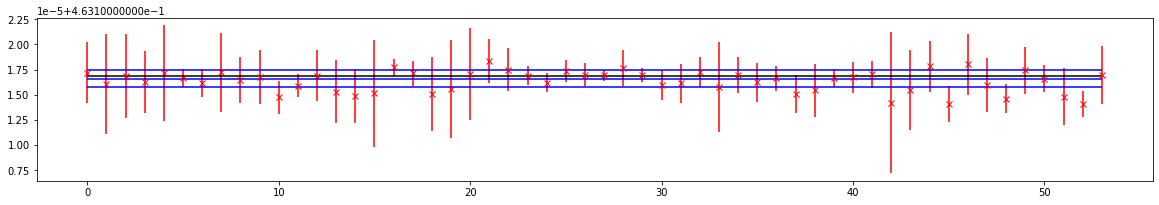

err: 2.91548304e-07  , std: 8.79500282e-07  


In [15]:
# Weighted mean & variance

# Do over samples for each signal, do over signals
# Gives more realistic error estimation

amplitude = torch.stack([spectrum[index] for index, spectrum in zip(f.ffrft_bin.to(torch.int64), f.ffrft_spectrum)])**2

f_out = f.frequency.reshape(54, -1)
s_out = s.reshape(54, -1)

center = weighted_mean(f_out, weight=amplitude.reshape(54, -1)/s_out**2)
spread = weighted_variance(f_out, weight=amplitude.reshape(54, -1)/s_out**2, center=center).sqrt()
plt.figure(figsize=(20, 3))
plt.errorbar(range(54), center.cpu().numpy(), yerr=spread.cpu().numpy(), fmt=' ', color='red', marker='x')
center, spread = weighted_mean(center, weight=1/spread**2), weighted_variance(center, weight=1/spread**2).sqrt()
plt.hlines(center.cpu().item() - spread.cpu().item(), 0, 53, color='blue')
plt.hlines(center.cpu().item(), 0, 53, color='blue')
plt.hlines(center.cpu().item() + spread.cpu().item(), 0, 53, color='blue')
plt.hlines(f_ref, 0, 53, color='black')
plt.show()

print(f'err: {abs(center.item() - f_ref):<16.9}, std: {spread.item():<16.9}')

# Example-28: Additional frequency processing

In [1]:
# In this example frequency and noise are computed for signals and samples
# Noise is used for weighting (or SNR)
# Weighted mean and variance are compared with regular mean and variance
# Outlies (signals or samples) are detected using different dispersion estimations
# Dispersion can be estimated with variance, weighted variance, biweight midvariance or interquatile range
# Data points outside given threshold (scaled dispersion) are considered to be outliers

# Different center and dispersion estimators are defined in harmonica.statistics
# Including trimmed and winsorized variants for mean and variance (not used in this example)

# Note, biweight midvariance or interquatile range are robust dispersion estimators, can be used when weights are not avalible

In [2]:
# Import

import epics
import numpy
import pandas
import torch
import nufft

import sys
sys.path.append('..')

from harmonica.util import LENGTH, make_mark, make_mask

from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter

from harmonica.statistics import mean, variance
from harmonica.statistics import weighted_mean, weighted_variance
from harmonica.statistics import median, biweight_midvariance
from harmonica.statistics import quantile, quartiles, interquartile_range, whiskers

from harmonica.anomaly import threshold

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())
print(torch.get_num_threads())

True
6


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Reference case

# Set parameters

length = 1024

# Set window

w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)

# Load TbT

d = Data.from_file(54, w, '../virtual_tbt.npy')

# Remove mean and apply window

d.window_remove_mean()
d.window_apply()

# Compute reference frequency

f = Frequency(d)
f('parabola')
f_ref, s_ref = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()

# Reset work

d.reset()

# Print results

print(f'{f_ref:<16.9}')
print(f'{s_ref:<16.9}')

0.463116901     
2.30523602e-16  


In [5]:
# Set data with noise

# Generate noise sigma for each signal

std = 1.0E-6*(25.0 + 75.0*torch.rand(54, dtype=dtype, device=device))

# Set test data

d.reset()
d.add_noise(std)
data = d.work
print(data.shape)

# Set spike

data[1, 128] += 0.5
data[1, 256] -= 0.5
data[25, 128] += 0.25
data[25, 256] -= 0.25

torch.Size([54, 1024])


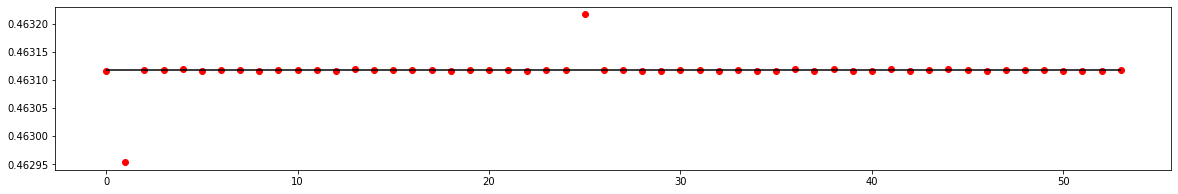

err: 9.57207391e-07  , std: 2.63974211e-05  
err: 9.22860901e-08  , std: 5.45661064e-07  


In [6]:
# Estimate the main frequency for each signal using 'parabola' interpolation of refined amplitude spectrum
# Estimate noise for each signal using optimal SVD

# Set data

w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
t = Data.from_data(w, data)

# Estimate noise

l = Filter(t)
_, s = l.estimate_noise(limit=32)

# Estimate frequency

t.window_remove_mean()
t.window_apply()
f = Frequency(t)
f('parabola')
t.reset()

# Set weight

weight = 1.0/s**2*torch.stack([spectrum[index] for index, spectrum in zip(f.ffrft_bin.to(torch.int64), f.ffrft_spectrum)])**2

# Plot frequencies for each signal

plt.figure(figsize=(20, 3))
plt.scatter(range(f.size), f.frequency.cpu().numpy(), color='red', marker='o')
plt.hlines(f_ref, 0, f.size - 1, color='black')
plt.show()

# Mean & variance

f_out = mean(f.frequency)
s_out = variance(f.frequency).sqrt()
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

# Weighted mean & variance

f_out = weighted_mean(f.frequency, weight=weight)
s_out = weighted_variance(f.frequency, weight=weight).sqrt()
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

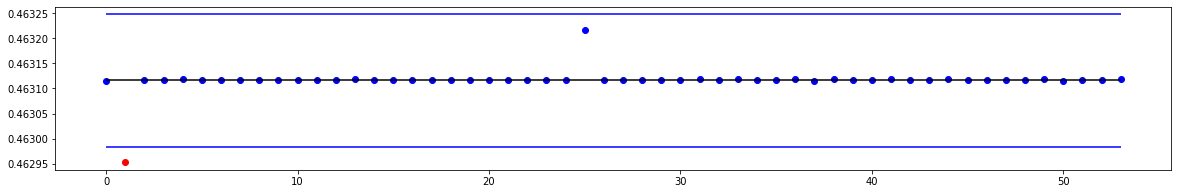

err: 2.11795992e-06  , std: 1.37747818e-05  
err: 9.22917316e-08  , std: 5.44732414e-07  


In [7]:
# Use mean and variance to remove outliers

time = torch.tensor(range(f.size), dtype=dtype, device=device)

factor = 5.0
center = mean(f.frequency)
spread = factor*variance(f.frequency).sqrt()
min_value, max_value = center - spread, center + spread
mask = threshold(f.frequency, min_value, max_value).squeeze(0)

plt.figure(figsize=(20, 3))
plt.scatter(time[~mask].cpu().numpy(), f.frequency[~mask].cpu().numpy(), color='red', marker='o')
plt.scatter(time[mask].cpu().numpy(), f.frequency[mask].cpu().numpy(), color='blue', marker='o')
plt.hlines(center.cpu().numpy(), 0, f.size - 1, color='black')
plt.hlines(center.cpu().numpy() - spread.cpu().numpy(), 0, f.size - 1, color='blue')
plt.hlines(center.cpu().numpy() + spread.cpu().numpy(), 0, f.size - 1, color='blue')
plt.show()

# Mean & variance

f_out = mean(f.frequency[mask])
s_out = variance(f.frequency[mask]).sqrt()
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

# Weighted mean & variance

weight = 1.0/s**2*torch.stack([spectrum[index] for index, spectrum in zip(f.ffrft_bin.to(torch.int64), f.ffrft_spectrum)])**2
f_out = weighted_mean(f.frequency, weight=weight*mask)
s_out = weighted_variance(f.frequency, weight=weight*mask).sqrt()
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

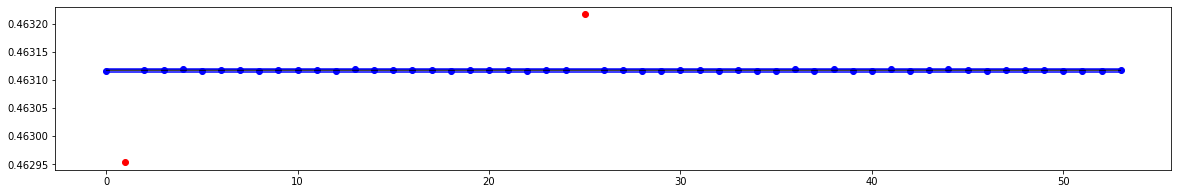

err: 2.29684872e-07  , std: 8.85327406e-07  
err: 9.22271344e-08  , std: 5.38191327e-07  


In [8]:
# Use weighted mean and variance to remove outliers

time = torch.tensor(range(f.size), dtype=dtype, device=device)

factor = 5.0
center = weighted_mean(f.frequency, weight=weight)
spread = factor*weighted_variance(f.frequency, weight=weight).sqrt()
min_value, max_value = center - spread, center + spread
mask = threshold(f.frequency, min_value, max_value).squeeze(0)

plt.figure(figsize=(20, 3))
plt.scatter(time[~mask].cpu().numpy(), f.frequency[~mask].cpu().numpy(), color='red', marker='o')
plt.scatter(time[mask].cpu().numpy(), f.frequency[mask].cpu().numpy(), color='blue', marker='o')
plt.hlines(center.cpu().numpy(), 0, f.size - 1, color='black')
plt.hlines(center.cpu().numpy() - spread.cpu().numpy(), 0, f.size - 1, color='blue')
plt.hlines(center.cpu().numpy() + spread.cpu().numpy(), 0, f.size - 1, color='blue')
plt.show()

# Mean & variance

f_out = mean(f.frequency[mask])
s_out = variance(f.frequency[mask]).sqrt()
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

# Weighted mean & variance

weight = 1.0/s**2*torch.stack([spectrum[index] for index, spectrum in zip(f.ffrft_bin.to(torch.int64), f.ffrft_spectrum)])**2
f_out = weighted_mean(f.frequency, weight=weight*mask)
s_out = weighted_variance(f.frequency, weight=weight*mask).sqrt()
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

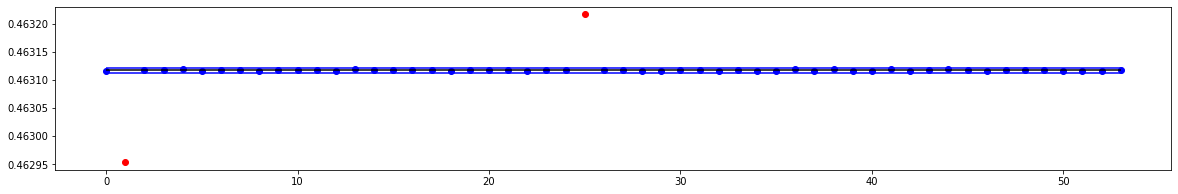

err: 2.29684872e-07  , std: 8.85327406e-07  
err: 9.22271344e-08  , std: 5.38191327e-07  


In [9]:
# Use median and biweight midvariance to remove outliers

time = torch.tensor(range(f.size), dtype=dtype, device=device)

factor = 5.0
center = median(f.frequency)
spread = factor*biweight_midvariance(f.frequency).sqrt()
min_value, max_value = center - spread, center + spread
mask = threshold(f.frequency, min_value, max_value).squeeze(0)

plt.figure(figsize=(20, 3))
plt.scatter(time[~mask].cpu().numpy(), f.frequency[~mask].cpu().numpy(), color='red', marker='o')
plt.scatter(time[mask].cpu().numpy(), f.frequency[mask].cpu().numpy(), color='blue', marker='o')
plt.hlines(center.cpu().numpy(), 0, f.size - 1, color='black')
plt.hlines(center.cpu().numpy() - spread.cpu().numpy(), 0, f.size - 1, color='blue')
plt.hlines(center.cpu().numpy() + spread.cpu().numpy(), 0, f.size - 1, color='blue')
plt.show()

# Mean & variance

f_out = mean(f.frequency[mask])
s_out = variance(f.frequency[mask]).sqrt()
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

# Weighted mean & variance

weight = 1.0/s**2*torch.stack([spectrum[index] for index, spectrum in zip(f.ffrft_bin.to(torch.int64), f.ffrft_spectrum)])**2
f_out = weighted_mean(f.frequency, weight=weight*mask)
s_out = weighted_variance(f.frequency, weight=weight*mask).sqrt()
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

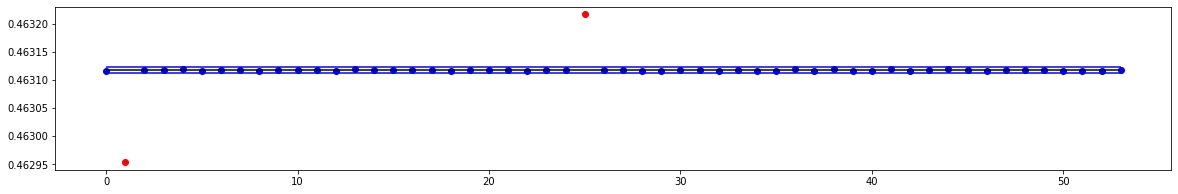

err: 2.29684872e-07  , std: 8.85327406e-07  
err: 9.22271344e-08  , std: 5.38191327e-07  


In [10]:
# Use quantiles to remove outliers

time = torch.tensor(range(f.size), dtype=dtype, device=device)

factor = 5.0
center = median(f.frequency)
value_min, value_max = whiskers(f.frequency, factor=factor)
mask = threshold(f.frequency, min_value, max_value).squeeze(0)

plt.figure(figsize=(20, 3))
plt.scatter(time[~mask].cpu().numpy(), f.frequency[~mask].cpu().numpy(), color='red', marker='o')
plt.scatter(time[mask].cpu().numpy(), f.frequency[mask].cpu().numpy(), color='blue', marker='o')
plt.hlines(center.cpu().numpy(), 0, f.size - 1, color='black')
plt.hlines(value_min.cpu().numpy(), 0, f.size - 1, color='blue')
plt.hlines(value_max.cpu().numpy(), 0, f.size - 1, color='blue')
plt.show()

# Mean & variance

f_out = mean(f.frequency[mask])
s_out = variance(f.frequency[mask]).sqrt()
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

# Weighted mean & variance

weight = 1.0/s**2*torch.stack([spectrum[index] for index, spectrum in zip(f.ffrft_bin.to(torch.int64), f.ffrft_spectrum)])**2
f_out = weighted_mean(f.frequency, weight=weight*mask)
s_out = weighted_variance(f.frequency, weight=weight*mask).sqrt()
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

In [11]:
# Estimate the main frequency for sampled signals using 'parabola' interpolation of refined amplitude spectrum
# Estimate noise for each sample, WLS fit to estimate sample spread

# Set data

w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
t = Data.from_data(w, data)

# Sample data

w = Window(512, 'cosine_window', 1.0, dtype=dtype, device=device)
t = Data.from_data(w, torch.cat([t.make_matrix(512, 8, t.work[i]) for i in range(54)]))
n = t.size//54

# Estimate noise for all samples

l = Filter(t)
_, s = l.estimate_noise(limit=32)

# Estimate frequency for each sample

t.window_remove_mean()
t.window_apply()
f = Frequency(t)
f('parabola')
t.reset()

# Set weight

weight = 1.0/s**2*torch.stack([spectrum[index] for index, spectrum in zip(f.ffrft_bin.to(torch.int64), f.ffrft_spectrum)])**2

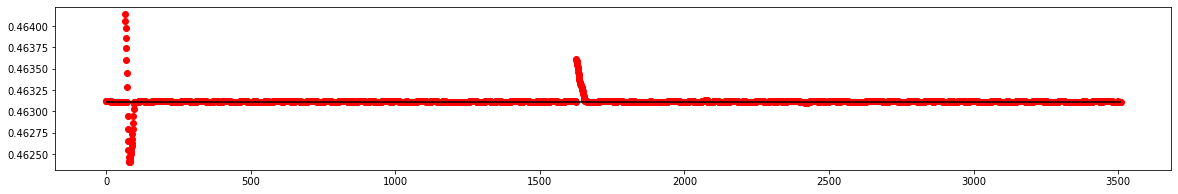

err: 7.79374517e-07  , std: 5.95903281e-05  
err: 6.31272712e-08  , std: 1.7768838e-06   


In [12]:
# Process by samples

# Plot frequencies for each sample

plt.figure(figsize=(20, 3))
plt.scatter(range(f.size), f.frequency.cpu().numpy(), color='red', marker='o')
plt.hlines(f_ref, 0, f.size - 1, color='black')
plt.show()

# Mean & variance

f_out = mean(f.frequency)
s_out = variance(f.frequency).sqrt()
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

# Weighted mean & variance

f_out = weighted_mean(f.frequency, weight=weight)
s_out = weighted_variance(f.frequency, weight=weight).sqrt()
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

err: 7.79374517e-07  , std: 1.94446986e-05  
err: 1.14369293e-08  , std: 5.00786157e-07  


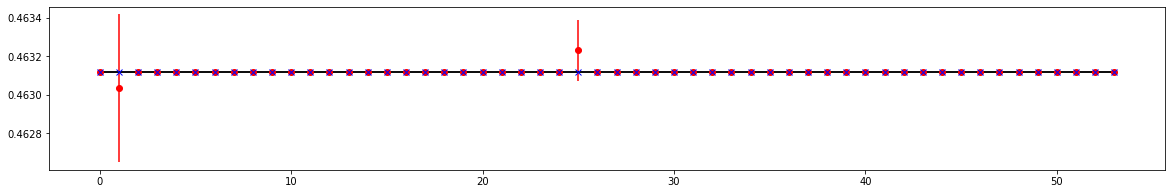

In [13]:
# Process by signals

plt.figure(figsize=(20, 3))

# Mean & variance

f_out = mean(f.frequency.reshape(54, -1))
s_out = variance(f.frequency.reshape(54, -1)).sqrt()

plt.errorbar(range(54), f_out.cpu().numpy(), yerr=s_out.cpu().numpy(), fmt=' ', color='red', marker='o')
plt.hlines(f_ref, 0, 54 - 1, color='black')

f_out, s_out = mean(f_out), variance(f_out).sqrt()
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

# Weighted mean & variance

f_out = weighted_mean(f.frequency.reshape(54, -1), weight=weight.reshape(54, -1))
s_out = weighted_variance(f.frequency.reshape(54, -1), weight=weight.reshape(54, -1)).sqrt()

plt.errorbar(range(54), f_out.cpu().numpy(), yerr=s_out.cpu().numpy(), fmt=' ', color='blue', marker='x')
plt.hlines(f_ref, 0, 54 - 1, color='black')

f_out, s_out = weighted_mean(f_out, weight=1/s_out**2), weighted_variance(f_out, weight=1/s_out**2).sqrt()
print(f'err: {abs(f_out - f_ref):<16.9}, std: {s_out:<16.9}')

plt.show()

In [14]:
# Data filtering based on (robust) dispecrion can be performed for all samples
# Samples outside the threshold region (or entier signals with such samples) can be removed

# Example-29: Detection of anomalies using frequency data

In [1]:
# In this example the objective is to detect signals with anomalies using frequency data

# To achieving this, shifted samples are generated from each signal
# For each sample frequency is computed
# These frequencies are used as features in anomaly detection

# For anomaly detection, several methods are used
# Threshold based detector is based on (robust) dispersion estimation
# In this case samples with frequencies outside threshold interval are marked as potential anomaly candidates
# DBSCAN is also used to flag anomaly candidates, samples with frequencies not in the main cluster are marked
# Local outlier factor and Isolation Forest are applied to frequencies
# The main hyperparameter for later methods is contamination

# Each method returns a mask with True/False values for each sample
# The number of flaged samples in a signal can be viewed as anomaly score

# For finial decision, the following procedure is performed
# Anomaly scores for each method are summed and signals with scores above the certain threshold are flagged
# Signals are also required to be flagged by several methods

# Note, spike anomalies in signals normaly appear in both planes, but this is not used here
# Anomaly might spoil only one plane

# Ones anomaly detection is done, several options are available
# One can discard all data and perform new measurement, since anomalies are normaly rare
# Flagged signals or samples can be removed from further computations
# Weights can be adjacted

In [2]:
# Import

import pandas
import torch

import sys
sys.path.append('..')

from harmonica.util import LENGTH, make_mark, make_mask

from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter

from harmonica.statistics import mean, variance, median, biweight_midvariance, standardize, rescale

from harmonica.anomaly import threshold, dbscan, local_outlier_factor, isolation_forest, score

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())
print(torch.get_num_threads())

True
6


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Import test data

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

# Set parameters

length = 1024

# Set initial data

w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)
x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device)[:, :length])
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device)[:, :length])

# Compute referense frequencies

x.window_remove_mean()
x.window_apply()
f_x = Frequency(x)
f_x('parabola')
x.reset()
nux = f_x.frequency.mean().cpu().item()
print(f'nux: {nux:12.9}, {f_x.frequency.std().cpu().item():12.9}')

y.window_remove_mean()
y.window_apply()
f_y = Frequency(y)
f_y('parabola')
y.reset()
nuy = f_y.frequency.mean().cpu().item()
print(f'nuy: {nuy:12.9}, {f_y.frequency.std().cpu().item():12.9}')

# Set noise

std_x = 1.0E-6*(25.0 + 50.0*torch.rand(x.size, dtype=dtype, device=device))
std_y = 1.0E-6*(25.0 + 50.0*torch.rand(y.size, dtype=dtype, device=device))

# Add noise

x.add_noise(std_x)
y.add_noise(std_y)

# Set data with noise

x, y = x.work, y.work

# Add anomalies (one signal with increased noise and two signals with spikes)

x[10] += 1.0E-3*torch.randn(length, dtype=dtype, device=device)
y[10] += 1.0E-3*torch.randn(length, dtype=dtype, device=device)
x[20, 128] += 0.1
y[20, 128] += 0.2
x[30, 256] -= 0.2
y[30, 256] -= 0.1

# Compute shifted frequencies

x = Data.from_data(w, x)
f_x = Frequency(x)
data_x = f_x.compute_shifted_frequency(512, 4)
print(data_x.shape)

y = Data.from_data(w, y)
f_y = Frequency(y)
data_y = f_y.compute_shifted_frequency(512, 4)
print(data_y.shape)

# Estimate frequencies with anomalies

print(f'nux: {mean(data_x.flatten()).cpu().item():12.9}, {variance(data_x.flatten()).sqrt().cpu().item():12.9}')
print(f'nuy: {mean(data_y.flatten()).cpu().item():12.9}, {variance(data_y.flatten()).sqrt().cpu().item():12.9}')

# Frequency error

print(f'error_x: {abs(nux - mean(data_x.flatten()).cpu().item()):12.9}')
print(f'error_y: {abs(nuy - mean(data_y.flatten()).cpu().item()):12.9}')

# Normalize data 

feature_x = standardize(data_x.flatten(), center_estimator=median, spread_estimator=biweight_midvariance)
feature_y = standardize(data_y.flatten(), center_estimator=median, spread_estimator=biweight_midvariance)

nux:  0.463116901, 2.18481102e-16
nuy:  0.423225367, 1.13097665e-16
torch.Size([54, 129])
torch.Size([54, 129])
nux:  0.463120123, 5.62546369e-05
nuy:  0.423227288, 3.68444531e-05
error_x: 3.22144724e-06
error_y: 1.92176082e-06


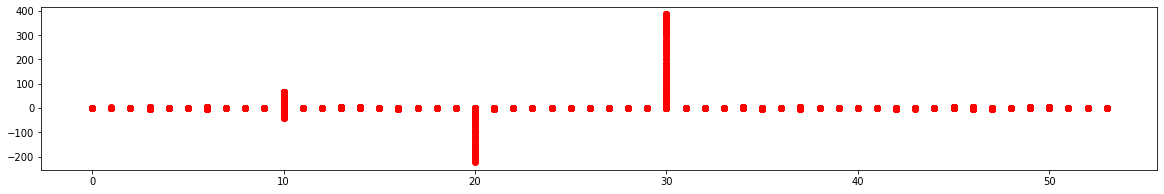

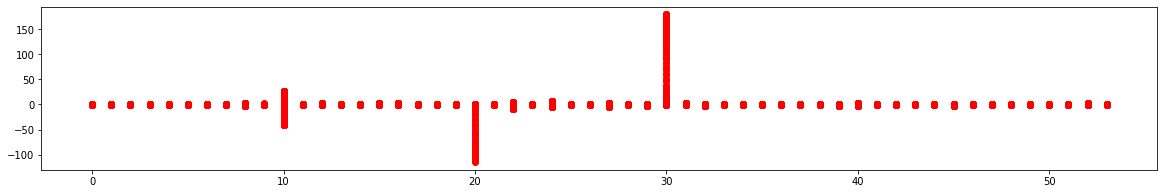

In [5]:
# Plot data grouped by signal

index = torch.ones(129, dtype=dtype, device=device)*torch.linspace(0, 54 - 1, 54, dtype=dtype, device=device).reshape(-1, 1)

plt.figure(figsize=(20, 3))
for i, value in zip(index, feature_x.reshape(54, -1)):
    plt.scatter(i.cpu().numpy(), value.cpu().numpy(), color='red')
plt.show()

plt.figure(figsize=(20, 3))
for i, value in zip(index, feature_y.reshape(54, -1)):
    plt.scatter(i.cpu().numpy(), value.cpu().numpy(), color='red')
plt.show()

# As it can be seen, signals with anomalies (10, 20 and 30) have large spread compared to other signals

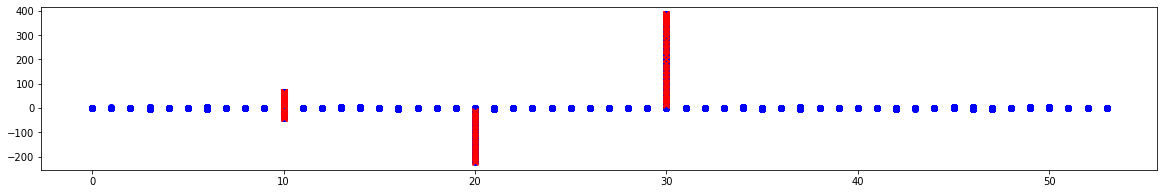

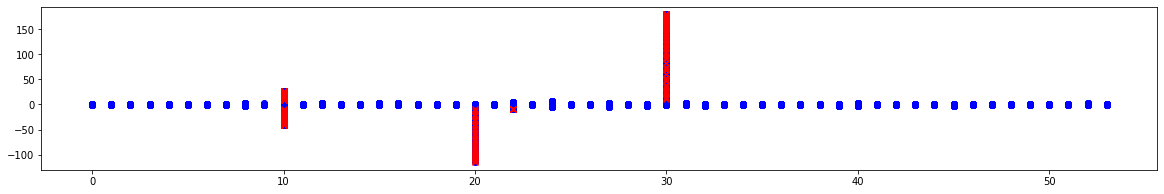

In [6]:
# Detect anomalies by threshold & plot marked samples (separately for x & y planes)

factor = 8.0

center = median(feature_x)
spread = biweight_midvariance(feature_x).sqrt()
min_value, max_value = center - factor*spread, center + factor*spread
threshold_mask_x = threshold(feature_x, min_value, max_value)

plt.figure(figsize=(20, 3))
plt.scatter(index.cpu().numpy(), feature_x.reshape_as(index).cpu().numpy(), color='blue')
plt.scatter(index[threshold_mask_x.reshape_as(index).logical_not()].cpu().numpy(), feature_x.reshape_as(index)[threshold_mask_x.reshape_as(index).logical_not()].cpu().numpy(), color='red', marker='x')
plt.show()

center = median(feature_y)
spread = biweight_midvariance(feature_y).sqrt()
min_value, max_value = center - factor*spread, center + factor*spread
threshold_mask_y = threshold(feature_y, min_value, max_value)

plt.figure(figsize=(20, 3))
plt.scatter(index.cpu().numpy(), feature_y.reshape_as(index).cpu().numpy(), color='blue')
plt.scatter(index[threshold_mask_y.reshape_as(index).logical_not()].cpu().numpy(), feature_y.reshape_as(index)[threshold_mask_y.reshape_as(index).logical_not()].cpu().numpy(), color='red', marker='x')
plt.show()

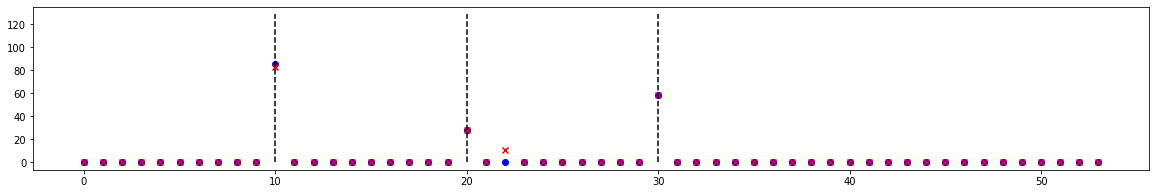

In [7]:
# Compute & plot anomaly scores (threshold)

threshold_score_x = score(54, threshold_mask_x)
threshold_score_y = score(54, threshold_mask_y)

plt.figure(figsize=(20, 3))
plt.scatter(range(54), threshold_score_x.cpu().numpy(), color='blue', marker='o')
plt.scatter(range(54), threshold_score_y.cpu().numpy(), color='red', marker='x')
plt.vlines([10, 20, 30], 0, 129, colors='black', linestyles='dashed')
plt.show()

threshold_score = threshold_score_x + threshold_score_y

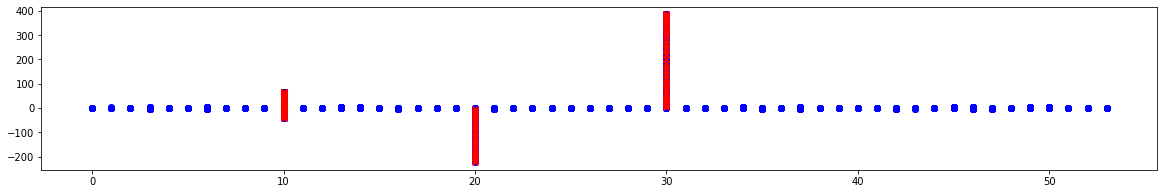

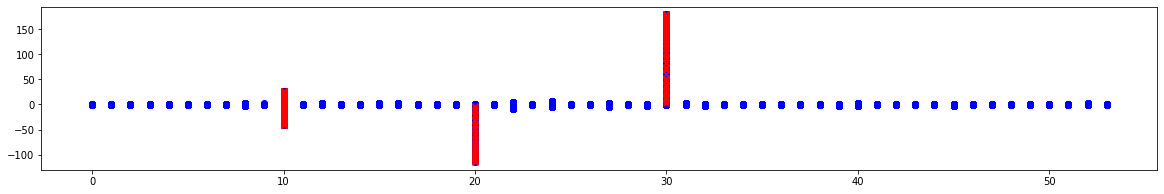

In [8]:
# Detect anomalies with DBSCAN

factor = 2.0
spread = 1.0
epsilon = factor*spread

dbscan_mask = dbscan(torch.stack([feature_x, feature_y]).T, epsilon)

plt.figure(figsize=(20, 3))
plt.scatter(index.cpu().numpy(), feature_x.reshape_as(index).cpu().numpy(), color='blue')
plt.scatter(index[dbscan_mask.reshape_as(index).logical_not()].cpu().numpy(), feature_x.reshape_as(index)[dbscan_mask.reshape_as(index).logical_not()].cpu().numpy(), color='red', marker='x')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(index.cpu().numpy(), feature_y.reshape_as(index).cpu().numpy(), color='blue')
plt.scatter(index[dbscan_mask.reshape_as(index).logical_not()].cpu().numpy(), feature_y.reshape_as(index)[dbscan_mask.reshape_as(index).logical_not()].cpu().numpy(), color='red', marker='x')
plt.show()

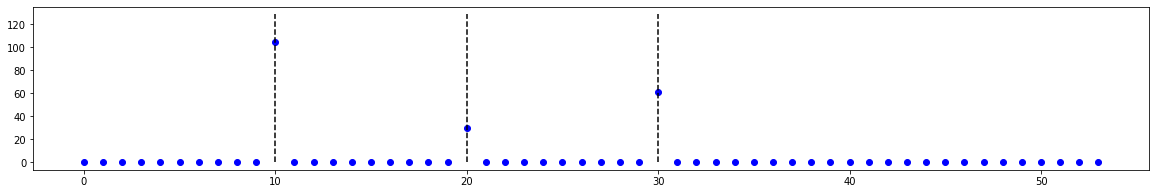

In [9]:
# Compute & plot anomaly scores (dbscan)

dbscan_score = score(54, dbscan_mask)
plt.figure(figsize=(20, 3))
plt.scatter(range(54), dbscan_score.cpu().numpy(), color='blue', marker='o')
plt.vlines([10, 20, 30], 0, 129, colors='black', linestyles='dashed')
plt.show()

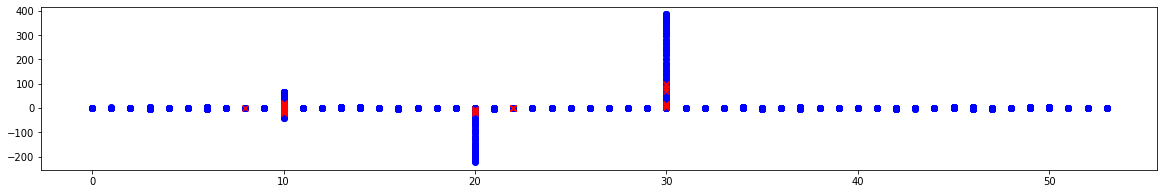

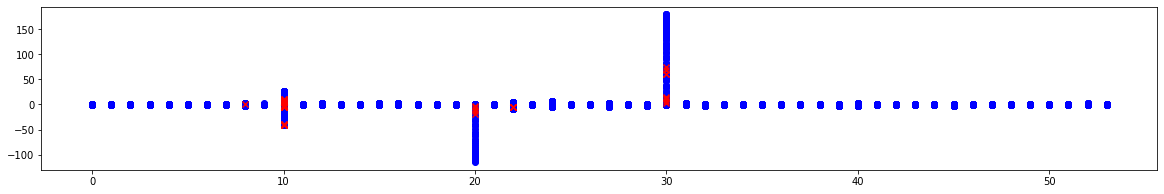

In [10]:
# Detect anomalies with local_outlier_factor

contamination = 0.01

local_outlier_factor_mask = local_outlier_factor(torch.stack([feature_x, feature_y]).T, contamination=contamination)

plt.figure(figsize=(20, 3))
plt.scatter(index.cpu().numpy(), feature_x.reshape_as(index).cpu().numpy(), color='blue')
plt.scatter(index[local_outlier_factor_mask.reshape_as(index).logical_not()].cpu().numpy(), feature_x.reshape_as(index)[local_outlier_factor_mask.reshape_as(index).logical_not()].cpu().numpy(), color='red', marker='x')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(index.cpu().numpy(), feature_y.reshape_as(index).cpu().numpy(), color='blue')
plt.scatter(index[local_outlier_factor_mask.reshape_as(index).logical_not()].cpu().numpy(), feature_y.reshape_as(index)[local_outlier_factor_mask.reshape_as(index).logical_not()].cpu().numpy(), color='red', marker='x')
plt.show()

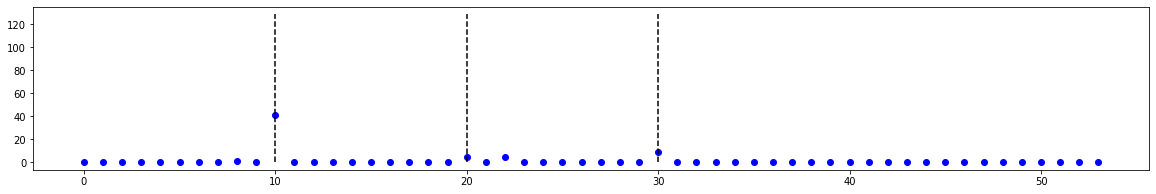

In [11]:
# Compute & plot anomaly scores (local_outlier_factor)

local_outlier_factor_score = score(54, local_outlier_factor_mask)
plt.figure(figsize=(20, 3))
plt.scatter(range(54), local_outlier_factor_score.cpu().numpy(), color='blue', marker='o')
plt.vlines([10, 20, 30], 0, 129, colors='black', linestyles='dashed')
plt.show()

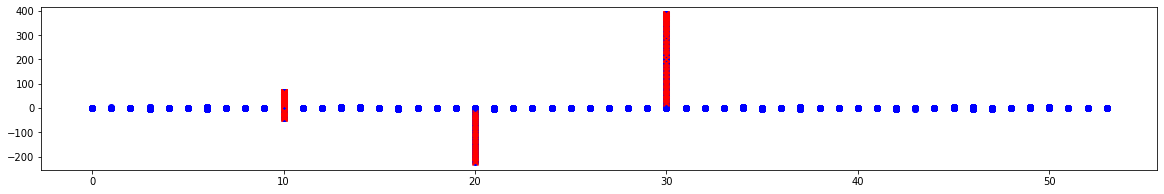

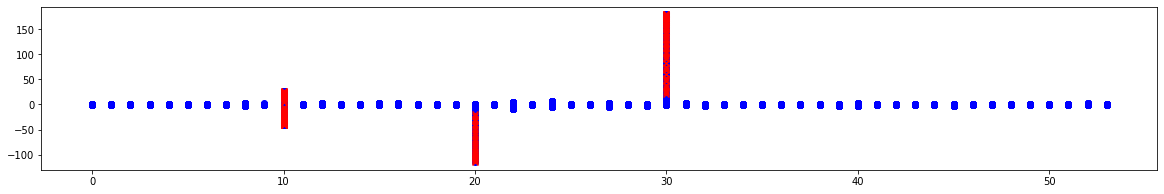

In [12]:
# Detect anomalies with isolation_forest

contamination = 0.02

isolation_forest_mask = isolation_forest(torch.stack([feature_x, feature_y]).T, contamination=contamination)

plt.figure(figsize=(20, 3))
plt.scatter(index.cpu().numpy(), feature_x.reshape_as(index).cpu().numpy(), color='blue')
plt.scatter(index[isolation_forest_mask.reshape_as(index).logical_not()].cpu().numpy(), feature_x.reshape_as(index)[isolation_forest_mask.reshape_as(index).logical_not()].cpu().numpy(), color='red', marker='x')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(index.cpu().numpy(), feature_y.reshape_as(index).cpu().numpy(), color='blue')
plt.scatter(index[isolation_forest_mask.reshape_as(index).logical_not()].cpu().numpy(), feature_y.reshape_as(index)[isolation_forest_mask.reshape_as(index).logical_not()].cpu().numpy(), color='red', marker='x')
plt.show()

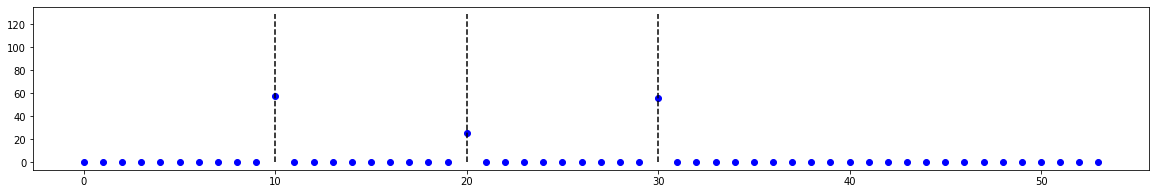

In [13]:
# Compute & plot anomaly scores (isolation_forest)

isolation_forest_score = score(54, isolation_forest_mask)
plt.figure(figsize=(20, 3))
plt.scatter(range(54), isolation_forest_score.cpu().numpy(), color='blue', marker='o')
plt.vlines([10, 20, 30], 0, 129, colors='black', linestyles='dashed')
plt.show()

In [14]:
# Note, both Local Outlier Factor and Isolation Forest can produce rather large number of false positives
# This is the case for large contamination factor

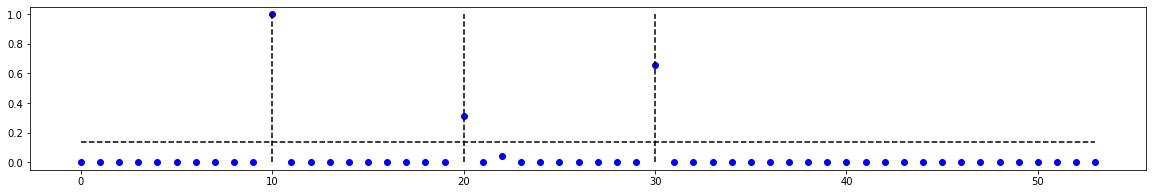

In [15]:
# Combine & threshold scores

total = (threshold_score + dbscan_score + local_outlier_factor_score + isolation_forest_score).to(torch.float64)
total = rescale(total, scale_min=0.0, scale_max=1.0)

limit = 5.0*variance(total) 
clear = total < limit

plt.figure(figsize=(20, 3))
plt.scatter(range(54), total.cpu().numpy(), color='blue', marker='o')
plt.vlines([10, 20, 30], 0, 1, colors='black', linestyles='dashed')
plt.hlines(limit.cpu().numpy(), 0, 53, colors='black', linestyles='dashed')
plt.show()

In [16]:
# Estimate frequency with removed anomaly signals (all samples are removed)

# + anomalies

print('+ anomalies')
print(f'nux: {mean(data_x.flatten()).cpu().item():12.9}, {variance(data_x.flatten()).sqrt().cpu().item():12.9}')
print(f'nuy: {mean(data_y.flatten()).cpu().item():12.9}, {variance(data_y.flatten()).sqrt().cpu().item():12.9}')
print(f'error_x: {abs(nux - mean(data_x.flatten()).cpu().item()):12.9}')
print(f'error_y: {abs(nuy - mean(data_y.flatten()).cpu().item()):12.9}')
print()

# - anomalies

print('- anomalies')
print(f'nux: {mean(data_x[clear].flatten()).cpu().item():12.9}, {variance(data_x[clear].flatten()).sqrt().cpu().item():12.9}')
print(f'nuy: {mean(data_y[clear].flatten()).cpu().item():12.9}, {variance(data_y[clear].flatten()).sqrt().cpu().item():12.9}')
print(f'error_x: {abs(nux - mean(data_x[clear].flatten()).cpu().item()):12.9}')
print(f'error_y: {abs(nuy - mean(data_y[clear].flatten()).cpu().item()):12.9}')
print()

# In general, with removed anomalies, both center and spread estimation are improved

+ anomalies
nux:  0.463120123, 5.62546369e-05
nuy:  0.423227288, 3.68444531e-05
error_x: 3.22144724e-06
error_y: 1.92176082e-06

- anomalies
nux:  0.463116607, 2.3086202e-06
nuy:  0.423225505, 3.39595967e-06
error_x: 2.94013887e-07
error_y: 1.38013427e-07



In [17]:
# Slightly better results might be obtained if only marked samples are removed (even better, if weights are avalible)
# Note, here x & y planes are used together, note, 'good' samples can be exluded based on the other plane

# Remove flagged samples only from marked signals

mask_x = threshold_mask_x*threshold_mask_y*dbscan_mask*local_outlier_factor_mask*isolation_forest_mask
mask_x = mask_x.reshape(54, -1)
mask_x[clear] = True

mask_y = threshold_mask_x*threshold_mask_y*dbscan_mask*local_outlier_factor_mask*isolation_forest_mask
mask_y = mask_y.reshape(54, -1)
mask_y[clear] = True

print(f'nux: {mean(data_x[mask_x].flatten()).cpu().item():12.9}, {variance(data_x[mask_x].flatten()).sqrt().cpu().item():12.9}')
print(f'nuy: {mean(data_y[mask_y].flatten()).cpu().item():12.9}, {variance(data_y[mask_y].flatten()).sqrt().cpu().item():12.9}')
print(f'error_x: {abs(nux - mean(data_x[mask_x].flatten()).cpu().item()):12.9}')
print(f'error_y: {abs(nuy - mean(data_y[mask_y].flatten()).cpu().item()):12.9}')
print()

nux:  0.463116621, 2.290595e-06
nuy:  0.423225465, 3.43210543e-06
error_x: 2.80546681e-07
error_y: 9.86599826e-08



# Example-30: Frequency estimation from complex data

In [1]:
# In this example frequency estimation is compared for real & complex data
# Complex normalized data is obtained using transport matrices between monitor locations
# Momentum at given location is computed using model transport matrix between given location and the next one
# Model normalization matrix is used to compute normalized data

In [2]:
# Import

import numpy
import torch
import nufft
import yaml

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.decomposition import Decomposition
from harmonica.filter import Filter
from harmonica.model import Model

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())
print(torch.get_num_threads())

True
6


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Set error & noise amplitude

error = 1.0E-3
noise = 1.0E-5

In [5]:
# Generate test trajectories

# Set model

model = Model(path='../config.yaml', model='uncoupled', dtype=dtype, device=device)

# Compute transport matrices

model.make_transport()

# Generate and apply errors

model.make_kick(error, 0.0E-3)
model.apply_error()

# Compute one-turn matrix

model.make_turn()


# Compute twiss

flag = model.make_twiss()
print(flag)

# Set initial condition

initial = torch.tensor([0.002, 0.0, 0.002, 0.0], dtype=dtype, device=device)

# Set number of iterations

length = 2**12

# Generate trajectories at monitor locations

trajectory =  model.make_trajectory(length, initial, full=False)
print(trajectory.shape)

True
torch.Size([54, 4096, 4])


In [6]:
# Model tunes

print(mod(torch.stack([model.nux, model.nuy]), 1.0))

# Fractional tunes with effect of errors

mod(model.tune, 1.0)

tensor([5.368830987374e-01, 5.767746333258e-01], dtype=torch.float64)


tensor([5.264071783437e-01, 5.767812953374e-01], dtype=torch.float64)

In [7]:
# Set data length

length = 2**10

# Set coordinates

qx = trajectory[..., 0]
qy = trajectory[..., 2]

# Add noise

qx += noise*torch.rand_like(qx)
qy += noise*torch.rand_like(qy)

# Get momenta

px = []
py = []

index_i = torch.tensor(model.monitor_index, dtype=torch.int64, device=device)
index_j = index_i.roll(-1)

for index, (i, j) in enumerate(zip(index_i, index_j)):
    i, j = int(i), int(j)
    matrix = model.matrix(i, j)  if i < j else model.matrix(i, j + model.size)
    qxi = qx[index, :length]
    qxj = qx[int(mod(index + 1, 54)), :length] if i < j else qx[int(mod(index + 1, 54)), 1:length + 1]
    qyi = qy[index, :length]
    qyj = qy[int(mod(index + 1, 54)), :length] if i < j else qy[int(mod(index + 1, 54)), 1:length + 1]
    pxi, pyi = model.get_momenta(matrix, qxi, qxj, qyi, qyj)
    px.append(pxi)
    py.append(pyi)
    
qx = qx[:, :length]
px = torch.stack(px)
qy = qy[:, :length]
py = torch.stack(py)

# Set normalized coordinates

qnx, pnx, qny, pny = [], [], [], []

for i, (qxi, pxi, qyi, pyi) in enumerate(zip(qx, px, qy, py)):
    index = model.monitor_index[i]
    normal = model.cs_normal(model.ax[index], model.bx[index], model.ay[index], model.by[index])
    qnxi, pnxi, qnyi, pnyi = normal.inverse() @ torch.stack([qxi, pxi, qyi, pyi])
    qnx.append(qnxi)
    pnx.append(pnxi)
    qny.append(qnyi)
    pny.append(pnyi)
    
qnx = torch.stack(qnx)
pnx = torch.stack(pnx)
qny = torch.stack(qny)
pny = torch.stack(pny)

# Set complex coordinates

cx = qnx - 1j*pnx
cy = qny - 1j*pny

In [8]:
# Estimate frequency from real data

win = Window.from_cosine(length, 1.0)

tbt = Data.from_data(win, qx)
fre = Frequency(tbt, f_range=(0.0, 0.5))
tbt.window_remove_mean()
tbt.window_apply()
fre('parabola')
fx_real = torch.clone(1.0 - fre.frequency)
tbt.reset()
fx_candan_real = 1.0 - fre.candan_get_frequency()

tbt = Data.from_data(win, qy)
fre = Frequency(tbt, f_range=(0.0, 0.5))
tbt.window_remove_mean()
tbt.window_apply()
fre('parabola')
fy_real = torch.clone(1.0 - fre.frequency)
tbt.reset()
fy_candan_real = 1.0 - fre.candan_get_frequency()

In [9]:
# Estimate frequency from complex data

win = Window.from_cosine(length, 1.0)

tbt = Data.from_data(win, cx)
fre = Frequency(tbt, f_range=(0.0, 1.0))
tbt.window_remove_mean()
tbt.window_apply()
fre('parabola')
fx_complex = torch.clone(fre.frequency)
tbt.reset()
fx_candan_complex = fre.candan_get_frequency()

tbt = Data.from_data(win, cy)
fre = Frequency(tbt, f_range=(0.0, 1.0))
tbt.window_remove_mean()
tbt.window_apply()
fre('parabola')
fy_complex = torch.clone(fre.frequency)
tbt.reset()
fy_candan_complex = fre.candan_get_frequency()

In [10]:
# Compare results

# Real

print(torch.stack([fx_real.mean(), fy_real.mean()]) - mod(model.tune, 1.0))
print(torch.stack([fx_real.std(), fy_real.std()]))
print()

# Complex

print(torch.stack([fx_complex.mean(), fy_complex.mean()]) - mod(model.tune, 1.0))
print(torch.stack([fx_complex.std(), fy_complex.std()]))
print()

tensor([-5.568233651942e-09, -2.375513008523e-09], dtype=torch.float64)
tensor([5.331658177526e-08, 6.658619136835e-08], dtype=torch.float64)

tensor([-4.702004452461e-09, -1.306652164246e-08], dtype=torch.float64)
tensor([5.149583847548e-08, 1.041401341050e-07], dtype=torch.float64)



In [11]:
# Without errors & noise, frequency estimation is better for complex data (more accurate and less spread)
# With errors, accuracy is close, but spread is smaller for complex data
# With error & noise results are similar (for signals with only one component)

In [12]:
# Candan (real)

print(torch.stack([fx_candan_real.mean(), fy_candan_real.mean()]) - mod(model.tune, 1.0))
print(torch.stack([fx_candan_real.std(), fy_candan_real.std()]))
print()

# Candan (complex)

print(torch.stack([fx_candan_complex.mean(), fy_candan_complex.mean()]) - mod(model.tune, 1.0))
print(torch.stack([fx_candan_complex.std(), fy_candan_complex.std()]))
print()

tensor([-1.209465860796e-09,  2.433581114403e-10], dtype=torch.float64)
tensor([4.827116961302e-08, 6.838247617323e-08], dtype=torch.float64)

tensor([-9.499059316909e-10, -1.722799425341e-08], dtype=torch.float64)
tensor([4.280347286114e-08, 1.237849584960e-07], dtype=torch.float64)



# Example-31: Frequency bootstrap

In [1]:
# In this example input signal is randomly sampled (with replacement)
# NUFFT is used to estimate frequencies for each random sample
# This allows some uncertainty quantification for a signal frequency

# Frequency uncertainty can be also estimated with OLS fit of parabola or using shifted samples

In [2]:
# Import

import numpy
import torch
import nufft
import yaml

import sys
sys.path.append('..')

from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())
print(torch.get_num_threads())

True
6


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [4]:
# Estimate frequency from a signal with noise using parabola estimator
# Here full signal is used to estimate (main) frequency

# Set parameters

length = 1024

# Set signal (harmonic signal with two components)

time = torch.linspace(1, length, length, dtype=dtype, device=device)
signal = 1.0*torch.cos(2.0*numpy.pi*1.0*0.12345*time) + 0.1*torch.cos(2.0*numpy.pi*2.0*0.12345*time)

# Set signal with noise

signal += 0.10*torch.randn_like(signal)

# Set tbt

w = Window.from_cosine(length, 1.0, dtype=dtype, device=device)
d = Data.from_data(w, signal.reshape(1, -1))

# Remove mean and apply window

d.window_remove_mean()
d.window_apply()

# Estimate frequency

f = Frequency(d)
f('parabola')

# Reset tbt
d.reset()

# Print estimation error

print(abs(0.12345 - f.frequency.mean().item()))

6.057901760642137e-07


In [5]:
# Estimate frequency using NUFFT from one random sample

# Set sample size

size = 512

# Set sample

time = torch.randint(length, (1, size), dtype=torch.int64, device=device).squeeze()
data = signal[time]

# Initial frequency estimation

grid = 2.0*numpy.pi*numpy.linspace(0.0, 0.5, len(time))
spectrum = numpy.abs(nufft.nufft1d3(time.cpu().numpy(), data.cpu().numpy(), grid))
index = numpy.argmax(spectrum)
frequency = grid[index]/(2*numpy.pi)

# Refined estimation

omega_min = grid[index - 1]
omega_max = grid[index + 1]
grid = numpy.linspace(omega_min, omega_max, len(grid))
spectrum = numpy.abs(nufft.nufft1d3(time.cpu().numpy(), data.cpu().numpy(), grid))
index = numpy.argmax(spectrum)
frequency = grid[index]/(2*numpy.pi)

# Print estimation error

print(abs(0.12345 - frequency))

1.4887542556921152e-05


In [6]:
# Bootstrap estimator
# Note, sample size can be larger than signal length

result = []
for _ in range(1024):
    
    size = 2048
    
    time = torch.randint(length, (1, size), dtype=torch.int64, device=device).squeeze()
    data = signal[time]

    grid = 2.0*numpy.pi*numpy.linspace(0.0, 0.5, len(time))
    spectrum = numpy.abs(nufft.nufft1d3(time.cpu().numpy(), data.cpu().numpy(), grid))
    index = numpy.argmax(spectrum)
    frequency = grid[index]/(2*numpy.pi)

    omega_min = grid[index - 1]
    omega_max = grid[index + 1]
    grid = numpy.linspace(omega_min, omega_max, len(grid))
    spectrum = numpy.abs(nufft.nufft1d3(time.cpu().numpy(), data.cpu().numpy(), grid))
    index = numpy.argmax(spectrum)
    frequency = grid[index]/(2*numpy.pi)
    
    result.append(frequency)
    
result = torch.tensor(result, dtype=dtype, device=device)

# Bootstrap result
# Note, data can be filtered/cleaned

print(abs(0.12345 - result.mean()))
print(result.std())

tensor(3.306565376560e-06, dtype=torch.float64)
tensor(8.707892494119e-06, dtype=torch.float64)


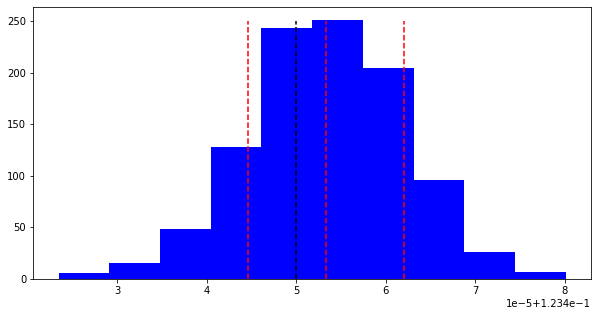

In [7]:
# Plot results

plt.figure(figsize=(10, 5))
plt.hist(result.cpu().numpy(), color='blue')
plt.vlines(0.12345, 0, 250, linestyles='dashed', color='black')
plt.vlines([result.mean() - result.std(), result.mean(), result.mean() + result.std()], 0, 250, linestyles='dashed', color='red')
plt.show()

In [8]:
# Or use compute_bootstrapped_frequency method to estimate frequencies and errors for all signals

f.compute_bootstrapped_frequency(length=1024, count=2048)

tensor([[1.234533282398e-01, 8.805543949980e-06]], dtype=torch.float64)

# Example-32: NUFFT applications

In [1]:
# In this example, similar to the previous one, NUFFT is used explicitly to bootstrap frequency
# Given a signal with noise, random samples (with repetition) are generated and NUFFT is performed in specified frequency interval
# This frequency interval can be identified from FFT, e.g. several bins around max bin frequency
# Also, NUFFTs from each sample are averaged to estimate the noise floor
# Additionally, frequency distribution is explored for a simple symplectic mapping for regular and chaotic initial conditions

In [2]:
# Import

import numpy
import torch
import nufft
import yaml

import sys
sys.path.append('..')

from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())
print(torch.get_num_threads())

True
16


In [3]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

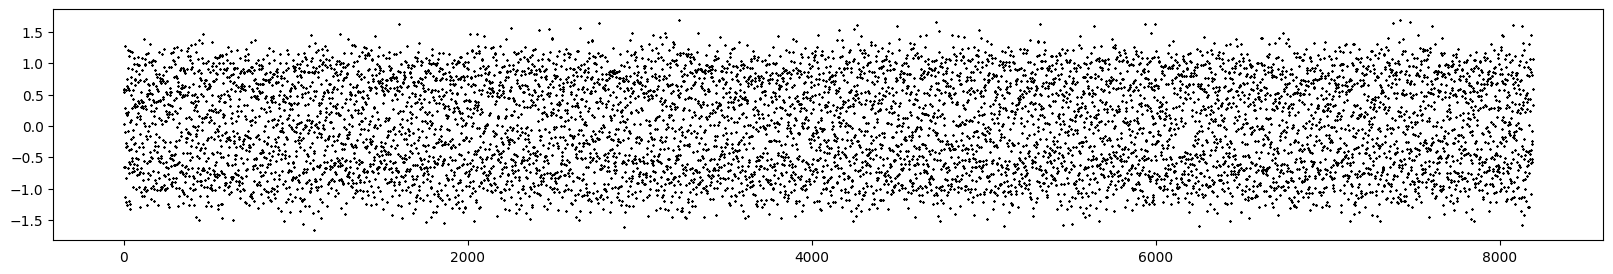

In [4]:
# Set parameters (1 signal with length 8192 and noise)

size, length = 1, 8192

# Set window

w = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)

# Set TbT data (1 signals with two components and random noise)

t = torch.linspace(1.0, length, length , dtype=dtype, device=device)
s = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.123456789*t) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.123456789*t) for i in range(1, size + 1)])
s += 0.25*torch.randn(length, dtype=dtype, device=device)

# Convert to numpy and plot signal

s = (s.squeeze()).numpy()

plt.figure(figsize=(20, 3))
plt.scatter(t.cpu().numpy(), s, color='black', marker='x', s=1)
plt.show()

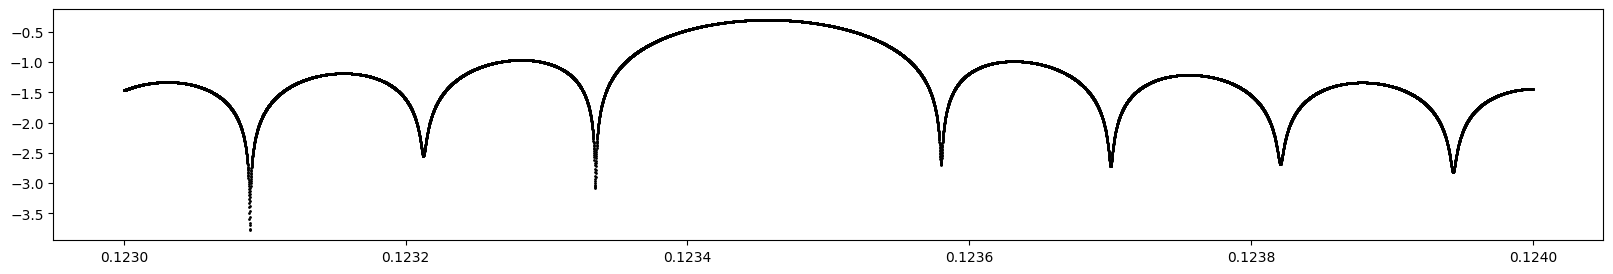

2.5991149343873587e-08


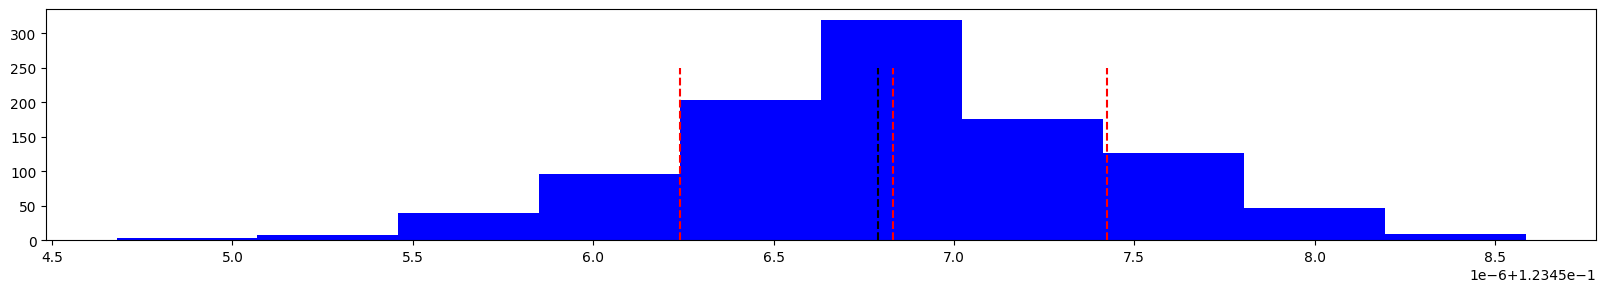

tensor(4.315833486424e-08, dtype=torch.float64)
tensor(5.918646836498e-07, dtype=torch.float64)


In [5]:
# Set initial frequency range
# Note, change range to zoom on the main maximum

f_min, f_max = 0.123, 0.124

# Generate (angular) frequencies
# Note, given a frequency range, resolution is defined by (f_max - f_min) over the number of frequency points

f = 2.0*numpy.pi*numpy.linspace(f_min, f_max, 2*len(t))

fft = nufft.nufft1d3(t, s, f)
plt.figure(figsize=(20, 3))
plt.scatter(f/(2.0*numpy.pi), numpy.log10(numpy.abs(fft)), color='black', s=1)
plt.show()

# Compute frequency from maximum
# Note, maximum can be fitted to obtain a potentialy more accurate result
# Frequency spread from full signal can be estimated from fit

print(abs(0.123456789 - f[numpy.argmax(numpy.abs(fft))]/(2.0*numpy.pi)))

# Perform bootstrap

# Set sample length and number of samples

limit = 8192
count = 1024

# Generate indices

index = torch.randint(limit, (count, limit), dtype=torch.int64, device=torch.device('cpu')).numpy()

# Compute frequencies for each sample

out = []
for i in index:
    out.append(f[numpy.argmax(numpy.abs(nufft.nufft1d3(t[i], s[i], f)))]/(2.0*numpy.pi))
out = torch.tensor(numpy.asarray(out), dtype=torch.float64)

# Plot frequency distribution
# Note, in this example frequency resolution is enough to see the effect of noise
# For small resolution the result will be 'quantized'
# Also the output can be cleaned from outliers

plt.figure(figsize=(20, 3))
plt.hist(out.cpu().numpy(), color='blue')
plt.vlines(0.123456789, 0, 250, linestyles='dashed', color='black')
plt.vlines([out.mean() - out.std(), out.mean(), out.mean() + out.std()], 0, 250, linestyles='dashed', color='red')
plt.show()

# Compute mean frequency and spread

print(abs(0.123456789 - out.mean()))
print(out.std())

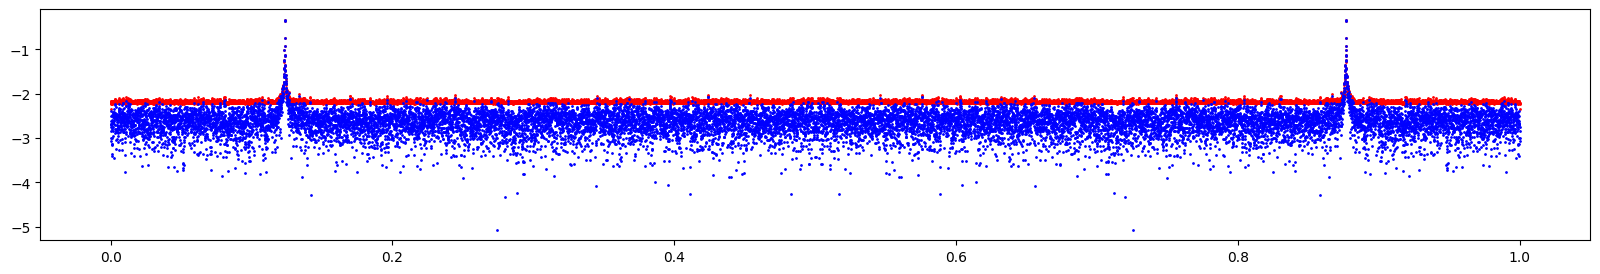

In [6]:
# Compute mean spectum

f_min, f_max = 0.0, 1.0
f = 2.0*numpy.pi*numpy.linspace(f_min, f_max, 2*len(t))

out = []
for i in index:
    out.append(numpy.log10(numpy.abs(nufft.nufft1d3(t[i], s[i], f))))
out = torch.tensor(numpy.asarray(out), dtype=torch.float64)

# Plot averaged spectrum vs full signal

plt.figure(figsize=(20, 3))
plt.scatter(f/(2.0*numpy.pi), out.T.mean(-1), color='red', s=1)
plt.scatter(f/(2.0*numpy.pi), numpy.log10(numpy.abs(nufft.nufft1d3(t, s, f))), color='blue', s=1)
plt.show()

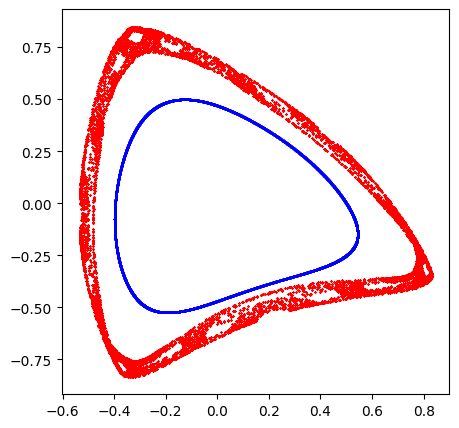

In [7]:
# Define nonlinear symplectic map

from math import pi

f1 = torch.tensor(2*pi*0.38, dtype=dtype, device=device)
f2 = torch.tensor(2*pi*0.41, dtype=dtype, device=device)

c1, s1 = f1.cos(), f1.sin()
c2, s2 = f2.cos(), f2.sin()

@torch.compile
def mapping(state):
    q1, p1, q2, p2 = state
    return torch.stack([c1*q1 + ((q1**2 - q2**2) + p1)*s1, c1*((q1**2 - q2**2) + p1) - q1*s1, c2*q2 + ((-2*q1*q2) + p2)*s2, c2*((-2*q1*q2) + p2) - q2*s2])

# Generate regular and chaotic orbits orbits

state = torch.tensor([0., 0., 0., 0.], dtype=dtype, device=device)
mapping(state)

regular = []
state = torch.tensor([0.50, 0., 0.01, 0.], dtype=dtype, device=device)
for _ in range(8192):
    state = mapping(state)
    regular.append(state)
regular = torch.stack(regular)

chaotic = []
state = torch.tensor([0.65, 0., 0.25, 0.], dtype=dtype, device=device)
for _ in range(8192):
    state = mapping(state)
    chaotic.append(state)
chaotic = torch.stack(chaotic)

q1, p1, q2, p2 = regular.T
Q1, P1, Q2, P2 = chaotic.T

# Plot otbits

plt.figure(figsize=(5, 5))
plt.scatter(q1.cpu().numpy(), p1.cpu().numpy(), marker='x', s=1, color='blue')
plt.scatter(Q1.cpu().numpy(), P1.cpu().numpy(), marker='x', s=1, color='red')
plt.show()

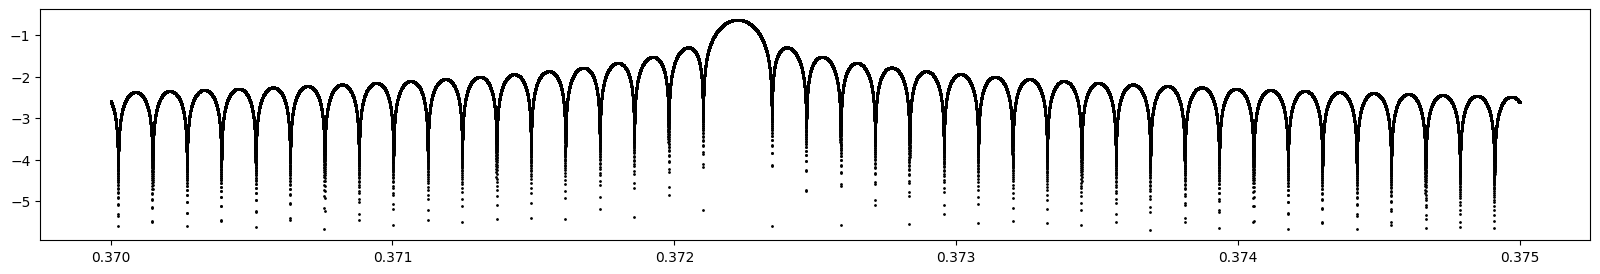

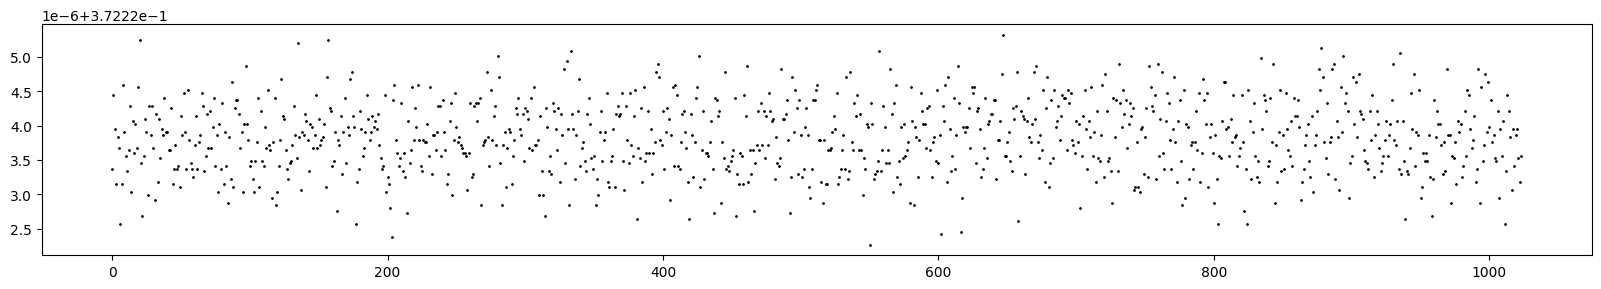

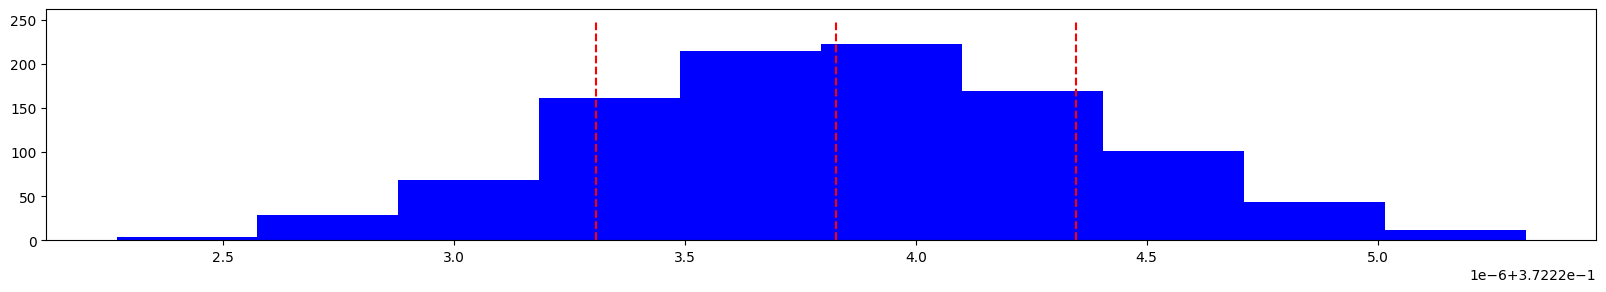

tensor(3.722238269612e-01, dtype=torch.float64)
tensor(5.206505837965e-07, dtype=torch.float64)


In [8]:
# Regular

l = len(q1)
t = torch.linspace(1.0, l, l , dtype=dtype, device=device)
f_min, f_max = 0.37, 0.375
f = 2.0*numpy.pi*numpy.linspace(f_min, f_max, 16*len(t))
s = q1.cpu().numpy()

fft = nufft.nufft1d3(t, s, f)

plt.figure(figsize=(20, 3))
plt.scatter(f/(2.0*numpy.pi), numpy.log10(numpy.abs(fft)), color='black', s=1)
plt.show()

limit = l
count = 1024
index = torch.randint(limit, (count, limit), dtype=torch.int64, device=torch.device('cpu')).numpy()
out = []
for i in index:
    out.append(f[numpy.argmax(numpy.abs(nufft.nufft1d3(t[i], s[i], f)))]/(2.0*numpy.pi))
out = torch.tensor(numpy.asarray(out), dtype=torch.float64)

plt.figure(figsize=(20, 3))
plt.scatter(range(len(out)), out.cpu().numpy(), color='black', s=1)
plt.show()

plt.figure(figsize=(20, 3))
plt.hist(out.cpu().numpy(), color='blue')
plt.vlines([out.mean() - out.std(), out.mean(), out.mean() + out.std()], 0, 250, linestyles='dashed', color='red')
plt.show()

print(out.mean())
print(out.std())

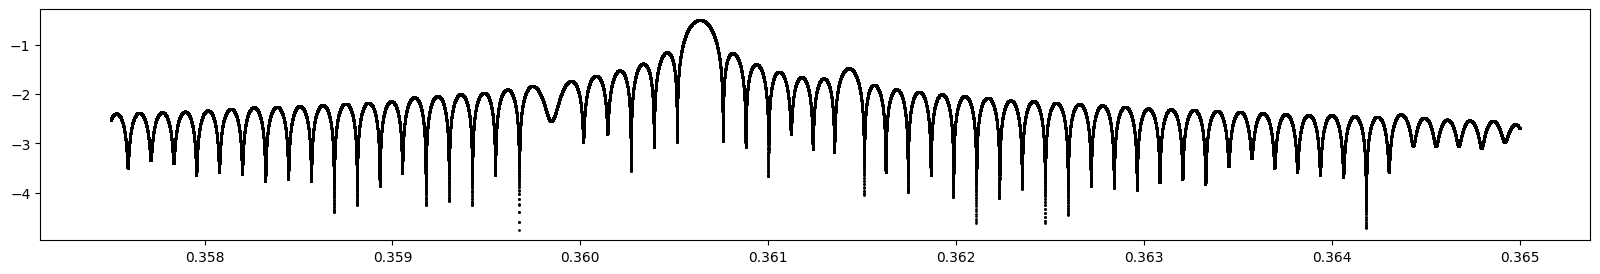

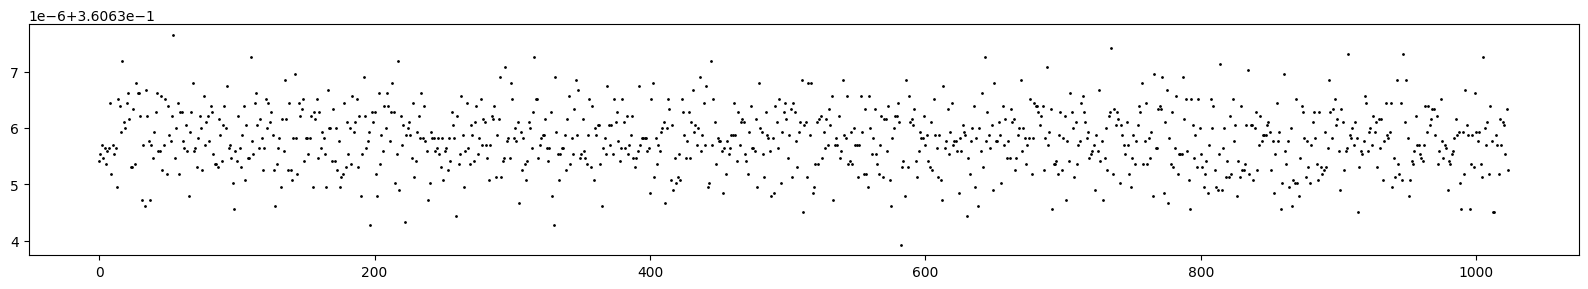

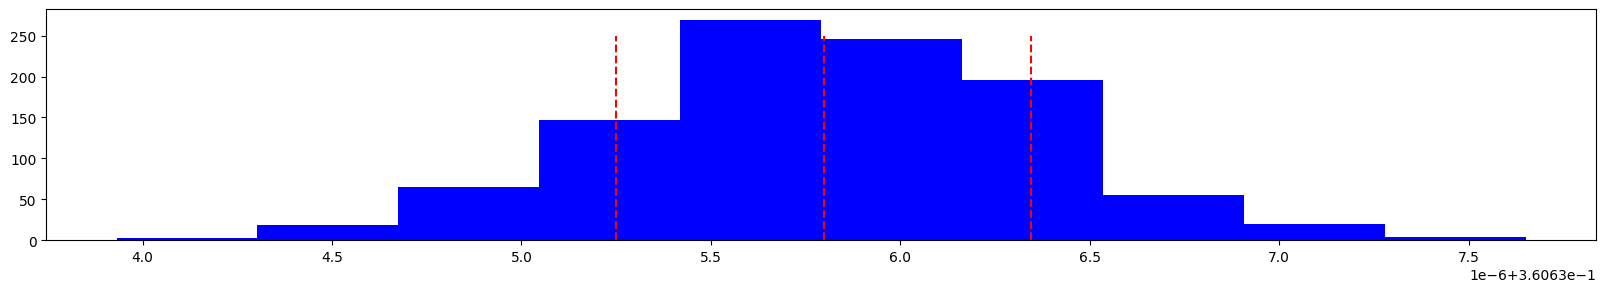

tensor(3.606357972775e-01, dtype=torch.float64)
tensor(5.473466113317e-07, dtype=torch.float64)


In [9]:
# Chaotic

l = len(Q1)
t = torch.linspace(1.0, l, l , dtype=dtype, device=device)
f_min, f_max = 0.3575, 0.3650
f = 2.0*numpy.pi*numpy.linspace(f_min, f_max, 16*len(t))
s = Q1.cpu().numpy()

fft = nufft.nufft1d3(t, s, f)

plt.figure(figsize=(20, 3))
plt.scatter(f/(2.0*numpy.pi), numpy.log10(numpy.abs(fft)), color='black', s=1)
plt.show()

limit = l
count = 1024
index = torch.randint(limit, (count, limit), dtype=torch.int64, device=torch.device('cpu')).numpy()
out = []
for i in index:
    out.append(f[numpy.argmax(numpy.abs(nufft.nufft1d3(t[i], s[i], f)))]/(2.0*numpy.pi))
out = torch.tensor(numpy.asarray(out), dtype=torch.float64)

plt.figure(figsize=(20, 3))
plt.scatter(range(len(out)), out.cpu().numpy(), color='black', s=1)
plt.show()

plt.figure(figsize=(20, 3))
plt.hist(out.cpu().numpy(), color='blue')
plt.vlines([out.mean() - out.std(), out.mean(), out.mean() + out.std()], 0, 250, linestyles='dashed', color='red')
plt.show()

print(out.mean())
print(out.std())